<a href="https://colab.research.google.com/github/Guo-Weiqiang/Master-Project/blob/main/baseline(EEGNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.optim as optim
import pandas as pd
from torchsummary import summary
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
from torch.nn import init


# reproducible
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA = 1

def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

TODO
- literature study, online?
- template, num of pages
- train, val(s+t), test, MK-MMD
- experiments (TCA, DANN, Ours)
- Datasets acquisition
- t-sne
- multi-source
- task transfer

- t sne plot(s/t domain, 不同的类不同颜色的点)
- DaNN
- Dataset(SEED)
- multi-source
- task transfer

```
# This is formatted as code
```




# Loss Part




In [ ]:
# 1. 成熟的数据集上，与主流的结果比（调整一下架构）
# 2. EEGNet 回归问题
# 3. 联合分布

# *. 可视化 t-sne 看看adapt之后的数据分布


# def MMD(source, target):
# 	"""
# 	mmd loss(linear)
# 	:param source: torch tensor: source data (Ds) with dimensions DxNs
# 	:param target: torch tensor: target data (Dt) with dimensons DxNt
# 	"""
# 	delta = source - target
# 	loss = torch.mean(torch.mm(delta, torch.transpose(delta, 0, 1)))

# 	return loss


# ref.
# 1. https://github.com/thuml/Xlearn/blob/master/pytorch/src/loss.py
# 2. https://github.com/MaterialsInformaticsDemo/DAN/blob/main/code/MK_MMD.py
# 3. https://github.com/thuml/Transfer-Learning-Library/blob/master/tllib/alignment/dan.py
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    # The simplest version: K = \beta * k where \beta=1
    n_samples_source = source.size(0)
    n_samples_target = target.size(0)
    total = torch.cat([source, target], dim=0)

    # Calculate the L2 distance matrix efficiently using matrix operations.
    total_xx = torch.sum(total * total, dim=1, keepdim=True)
    L2_distance = total_xx - 2.0 * torch.matmul(total, total.t()) + total_xx.t()
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        # Set the average value of distance matrix as the bandwidth
        bandwidth = torch.sum(L2_distance.data) / (n_samples_source * n_samples_target - n_samples_source)

    bandwidth /= kernel_mul ** (kernel_num // 2) #
    # bandwidth range [2^{-4}*sigma, 2^4*sigma]
    bandwidth_list = [bandwidth * (kernel_mul ** (1 * i)) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val) # final gaussian kernel matrix



def MK_MMD(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=1.68): # fix_sigma from None to 1.68
    n_s, n_t = source.size(0), target.size(0)

    kernels = gaussian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)

    # Efficiently calculate loss components using vectorized operations.
    SS = torch.triu(kernels[:n_s, :n_s], diagonal=1).sum() / float(n_s * n_s)
    TT = torch.triu(kernels[-n_t:, -n_t:], diagonal=1).sum() / float(n_t * n_t)
    ST = -kernels[:n_s, -n_t:].sum() / float(n_s * n_t)
    TS = -kernels[-n_t:, :n_s].sum() / float(n_s * n_t)

    loss = torch.abs(SS + TT - ST - TS)

    # return loss
    # loss1 = torch.triu(kernels[:batch_size, :batch_size], diagonal=1).sum() + torch.triu(kernels[batch_size:, batch_size:], diagonal=1).sum()
    # loss1 = loss1 / float(batch_size * batch_size / 2)

    # loss2 = -kernels[:batch_size, batch_size:].sum() - kernels[batch_size:, :batch_size].sum()
    # loss2 = loss2 / float(batch_size * batch_size)

    return loss

def MMD(Xs, Xt):
    ns, nt = Xs.size(0), Xt.size(0)

    # linear kernel version
    mmd_s = (Xs @ Xs.t()).sum() / (ns * ns)
    mmd_t = (Xt @ Xt.t()).sum() / (nt * nt)
    mmd_st = (Xs @ Xt.t()).sum() * 2.0 / (ns * nt)
    loss = mmd_s - mmd_st + mmd_t

    return torch.abs(loss)


def JMMD_Linear(source_list, target_list, kernel_muls=[2.0, 2.0, 2.0], kernel_nums=[5, 5, 1], fix_sigma_list=[None, None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = gaussian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    # Linear version
    # loss = 0
    # for i in range(batch_size):
    #     s1, s2 = i, (i+1) % batch_size
    #     t1, t2 = s1 + batch_size, s2 + batch_size
    #     loss += joint_kernels[s1, s2] + joint_kernels[t1, t2]
    #     loss -= joint_kernels[s1, t2] + joint_kernels[s2, t1]

    s1 = torch.arange(batch_size)
    s2 = (s1 + 1) % batch_size
    t1 = s1 + batch_size
    t2 = s2 + batch_size

    # Compute the loss in a vectorized way
    loss = torch.sum(joint_kernels[s1, s2] + joint_kernels[t1, t2] - joint_kernels[s1, t2] - joint_kernels[s2, t1])
    return torch.abs(loss) / float(batch_size) # loss might be negative



def _primal_kernel(Xs, Xt):
    Z = torch.cat((Xs.T, Xt.T), 1)  # Xs / Xt: batch_size * k
    return Z


def _linear_kernel(Xs, Xt):
    Z = torch.cat((Xs, Xt), 0)  # Xs / Xt: batch_size * k
    K = torch.mm(Z, Z.T)
    return K


def _rbf_kernel(Xs, Xt, sigma):
    Z = torch.cat((Xs, Xt), 0)
    ZZT = torch.mm(Z, Z.T)
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.T
    K = torch.exp(-exponent / (2 * sigma ** 2))
    return K

# functions to compute the marginal MMD with rbf kernel
def rbf_mmd(Xs, Xt, sigma):
    device = Xs.device

    K = _rbf_kernel(Xs, Xt, sigma)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    e = torch.cat((1 / m * torch.ones(m, 1), -1 / m * torch.ones(m, 1)), 0).to(device)
    M = e * e.T
    tmp = torch.mm(torch.mm(K, M), K.T)
    loss = torch.trace(tmp).to(device)
    return loss

# functions to compute rbf kernel JMMD
def rbf_jmmd(Xs, Ys, Xt, Yt0, sigma):
    device = Xs.device

    K = _rbf_kernel(Xs, Xt, sigma)
    n = K.size(0)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    e = torch.cat((1 / m * torch.ones(m, 1), -1 / m * torch.ones(m, 1)), 0).to(device)
    C = len(torch.unique(Ys))
    M = e * e.T * C
    for c in torch.unique(Ys):
        e = torch.zeros(n, 1, device=device)
        e[:m][Ys == c] = 1 / len(Ys[Ys == c])
        if len(Yt0[Yt0 == c]) == 0:
            e[m:][Yt0 == c] = 0
        else:
            e[m:][Yt0 == c] = -1 / len(Yt0[Yt0 == c])
        M = M + e * e.T
    M = M / torch.norm(M, p='fro')  # can reduce the training loss only for jmmd
    tmp = torch.mm(torch.mm(K, M), K.T)
    loss = torch.trace(tmp).to(device)
    return loss


def rbf_jpmmd(Xs, Ys, Xt, Yt0, sigma):
    device = Xs.device

    K = _rbf_kernel(Xs, Xt, sigma)
    n = K.size(0)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    M = 0
    for c in torch.unique(Ys):
        e = torch.zeros(n, 1, device=device)
        e[:m] = 1 / len(Ys)
        if len(Yt0[Yt0 == c]) == 0:
            e[m:] = 0
        else:
            e[m:] = -1 / len(Yt0)
        M = M + e * e.T
    tmp = torch.mm(torch.mm(K, M), K.T)
    loss = torch.trace(tmp).to(device)
    return loss


# functions to compute rbf kernel DJP-MMD
def rbf_djpmmd(Xs, Ys, Xt, Yt0, sigma):
    # Assuming _rbf_kernel is already optimized and running on the correct device
    K = _rbf_kernel(Xs, Xt, sigma)
    m, C = Xs.size(0), 2  # Assuming number of classes C is fixed at 2

    # Ensure all tensors start on the same device, ideally on the GPU if available
    device = Xs.device
    Ns = torch.zeros(m, C, device=device).scatter_(1, Ys.unsqueeze(1), 1) / m
    Nt = torch.zeros(m, C, device=device)
    if len(torch.unique(Yt0)) == 1:
        Nt = torch.zeros(m, C, device=device).scatter_(1, Yt0.unsqueeze(1), 1) / m

    Rmin_1 = torch.cat((torch.mm(Ns, Ns.T), torch.mm(-Ns, Nt.T)), 0)
    Rmin_2 = torch.cat((torch.mm(-Nt, Ns.T), torch.mm(Nt, Nt.T)), 0)
    Rmin = torch.cat((Rmin_1, Rmin_2), 1)

    # For discriminability
    Ms = torch.empty(m, (C - 1) * C).to(device)
    Mt = torch.empty(m, (C - 1) * C).to(device)
    for i in range(0, C):
        idx = torch.arange((C - 1) * i, (C - 1) * (i + 1))
        Ms[:, idx] = Ns[:, i].repeat(C - 1, 1).T
        tmp = torch.arange(0, C)
        Mt[:, idx] = Nt[:, tmp[tmp != i]]
    Rmax_1 = torch.cat((torch.mm(Ms, Ms.T), torch.mm(-Ms, Mt.T)), 0)
    Rmax_2 = torch.cat((torch.mm(-Mt, Ms.T), torch.mm(Mt, Mt.T)), 0)
    Rmax = torch.cat((Rmax_1, Rmax_2), 1)

    M = Rmin - 0.1 * Rmax
    # M = Rmin + Rmax
    # Operate in the same device as K and M to avoid device transfers
    tmp = torch.mm(torch.mm(K, M), K.T).to(device)
    loss = torch.trace(tmp)

    return loss


def compute_sigma(H):
    dists = torch.pdist(H)
    sigma = dists.median() / 2

    return sigma.detach()

def GaussianMatrix(X,Y,sigma, if_use_cdist=False, median_sigma = False):
    if not if_use_cdist:
        size1 = X.size()
        size2 = Y.size()
        G = (X*X).sum(-1)
        H = (Y*Y).sum(-1)
        Q = G.unsqueeze(-1).repeat(1,size2[0])
        R = H.unsqueeze(-1).T.repeat(size1[0],1)
        # print(G.shape, R.shape, X.shape, Y.shape, Q.shape, R.shape)
        H = Q + R - 2 * X @(Y.T)
    else:
        H = torch.cdist(X, Y, p=2)**2

    if sigma > 0:
        H = torch.exp(-H / 2 / sigma**2)
    else:
        if median_sigma:
            sigma = compute_sigma(H)
            H = torch.exp(-H / 2 / sigma / 2)
        else:
            sigma = H.mean().detach()
            H = torch.exp(-H / sigma)

    return H



# CKB loss
def CCS(x1, x2, y1, y2, sigma = -1, if_use_cdist=False, median_sigma=False):
    # Input: N x d

    K1 = GaussianMatrix(x1, x1, sigma, if_use_cdist, median_sigma) # a lot of 0 (1560)

    K2 = GaussianMatrix(x2, x2, sigma, if_use_cdist, median_sigma) # 1560 0

    L1 = GaussianMatrix(y1, y1, sigma, if_use_cdist, median_sigma)
    L2 = GaussianMatrix(y2, y2, sigma, if_use_cdist, median_sigma)

    #print(x1.shape, x2.shape, y1.shape, y2.shape, K1.shape, K2.shape, L1.shape, L2.shape)

    K12 = GaussianMatrix(x1, x2, sigma, if_use_cdist, median_sigma) # nan happens  1600 0 ---> all zeros --> makes the later part nan
    L12 = GaussianMatrix(y1, y2, sigma, if_use_cdist, median_sigma) #

    K21 = GaussianMatrix(x2, x1, sigma, if_use_cdist, median_sigma) # nan happens  1600 0
    L21 = GaussianMatrix(y2, y1, sigma, if_use_cdist, median_sigma)

    H1 = K1*L1 # 1560 0
    self_term1 = (H1.sum(-1) / ((K1.sum(-1)) ** 2)).sum(0) #

    H2 = K2*L2
    self_term2 = (H2.sum(-1) / ((K2.sum(-1)) ** 2)).sum(0)

    ##################################DEBUG#################################################
    H3 = K12*L12
    cross_term1 = (H3.sum(-1) / ((K1.sum(-1)) * (K12.sum(-1)))).sum(0) # # nan first happens
    ##################################DEBUG################################################
    H4 = K21*L21
    cross_term2 = (H4.sum(-1) / ((K2.sum(-1))*(K21.sum(-1)))).sum(0)

    cs1 = -2*torch.log(cross_term1) + torch.log(self_term1) + torch.log(self_term2)
    cs2 = -2*torch.log(cross_term2) + torch.log(self_term1) + torch.log(self_term2)


    return ((cs1 + cs2) / 2)

def CS(x1, x2, sigma = 10, if_use_cdist=False, median_sigma=False):
    K1 = GaussianMatrix(x1,x1,sigma, if_use_cdist, median_sigma)
    K2 = GaussianMatrix(x2,x2,sigma, if_use_cdist, median_sigma)

    K12 = GaussianMatrix(x1,x2,sigma, if_use_cdist, median_sigma)

    dim1 = K1.shape[0]
    self_term1 = K1.sum()/(dim1**2)

    dim2 = K2.shape[0]
    self_term2 = K2.sum()/(dim2**2)

    cross_term = K12.sum()/(dim1*dim2)

    cs =  -2*torch.log(cross_term) + torch.log(self_term1) + torch.log(self_term2)

    return cs

# 1. Model Part

In [ ]:


# ref.
# 1. https://github.com/agrija9/Deep-Unsupervised-Domain-Adaptation/blob/master/DDC/model.py
class EEGNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_ReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )
        self.classify = nn.Sequential(
            # nn.Linear(736, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, n_output, bias=True)

            # original classifier
            nn.Linear(736, n_output, bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        features = self.separableConv(out)
        out = self.classify(features)
        return out, features




class EEGNet_DDC(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DDC, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten(),
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        features_src = self.separableConv(source)
        source = self.bottleneck(features_src)
        # print(source.shape)

        mmd_loss = 0
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        features_tar = self.separableConv(target)
        target = self.bottleneck(features_tar)
        # print(target.shape)
        mmd_loss += MMD(source, target)

        result = self.classifier(source)

        return result, mmd_loss, source, target


class EEGNet_DAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        mmd_loss1 = MK_MMD(f1_s, f1_t)
        mmd_loss2 = MK_MMD(f2_s, f2_t)

        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)
        mmd_loss3 = MK_MMD(result_s, result_t) # P(Y)
        mmd_loss = 1 * mmd_loss1 + 1 * mmd_loss2 + 1 * mmd_loss3

        return result_s, mmd_loss, f2_s, f2_t



class EEGNet_JAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_JAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)

        source_list = [f1_s, f2_s, result_s]
        target_list = [f1_t, f2_t, result_t]
        mmd_loss = JMMD_Linear(source_list, target_list) # P(Y)

        return result_s, mmd_loss, f2_s, f2_t


class EEGNet_DA1(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_DA1, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )
        self.bottleneck = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
        )
        self.classify = nn.Sequential(
            # original classifier
            nn.Linear(256, n_output, bias=True)
        )

    def forward(self, source, target):
        out = self.firstConv(source)
        out = self.depthwiseConv(out)
        out = self.separableConv(out)
        features_src = self.bottleneck(out)
        out = self.classify(features_src)

        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        features_tar = self.bottleneck(target)

        return out, features_src, features_tar

# 2. Loss Part

# 3. Evaluation Part

## 3.1 Data Import

In [ ]:
import numpy as np


def read_bci_data():
    """
    two subjects: S4b, X11b
    The experiment consists of 3 sessions for each subject. Each session consists of 4 to 9 runs
    """
    S4b_train = np.load('drive/MyDrive/EEGNet/S4b_train.npz')
    X11b_train = np.load('drive/MyDrive/EEGNet/X11b_train.npz')
    S4b_test = np.load('drive/MyDrive/EEGNet/S4b_test.npz')
    X11b_test = np.load('drive/MyDrive/EEGNet/X11b_test.npz')

    source_data = np.concatenate((S4b_train['signal'], S4b_test['signal']), axis=0)
    source_label = np.concatenate((S4b_train['label'], S4b_test['label']), axis=0)
    target_data = np.concatenate((X11b_train['signal'], X11b_test['signal']), axis=0)
    target_label = np.concatenate((X11b_train['label'], X11b_test['label']), axis=0)

    source_label = source_label - 1
    target_label = target_label - 1
    source_data = np.transpose(np.expand_dims(source_data, axis=1), (0, 1, 3, 2))
    target_data = np.transpose(np.expand_dims(target_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(source_data))
    source_data[mask] = np.nanmean(source_data)


    mask = np.where(np.isnan(target_data))
    target_data[mask] = np.nanmean(target_data)


    source_data = torch.from_numpy(source_data).float()
    target_data = torch.from_numpy(target_data).float()
    source_label = torch.tensor(source_label, dtype=torch.long)
    target_label = torch.tensor(target_label, dtype=torch.long)
    val_data = target_data
    val_label = target_label

    print(source_data.shape, source_label.shape, val_data.shape, val_label.shape, target_data.shape, target_label.shape)

    return source_data, source_label, val_data, val_label, target_data, target_label


source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()


torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


### T-SNE Visualization

In [ ]:
s = source_label.numpy()
t = val_label.numpy()
print(s.shape, t.shape)

unique_values, counts = np.unique(s, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

unique_values, counts = np.unique(t, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

source_class0_index = np.where(s == 0.0)
source_class1_index = np.where(s == 1.0)
target_class0_index = np.where(t == 0.0)
target_class1_index = np.where(t == 1.0)

print(len(source_class0_index[0]), len(source_class1_index[0]), len(target_class0_index[0]), len(target_class1_index[0]))

(1080,) (1080,)
Value: 0, Count: 540
Value: 1, Count: 540
Value: 0, Count: 540
Value: 1, Count: 540
540 540 540 540


In [ ]:
print(source_class0_index)

(array([   2,    6,    8,   10,   12,   13,   14,   15,   17,   18,   21,
         23,   24,   27,   30,   33,   35,   38,   39,   42,   44,   45,
         46,   47,   49,   51,   54,   55,   56,   57,   60,   62,   64,
         69,   72,   73,   75,   77,   78,   79,   81,   84,   85,   87,
         91,   95,   97,   98,   99,  100,  102,  104,  107,  110,  111,
        113,  114,  116,  125,  128,  129,  131,  133,  134,  136,  137,
        138,  139,  140,  141,  146,  150,  152,  155,  156,  157,  160,
        163,  164,  165,  166,  167,  169,  171,  176,  179,  181,  184,
        185,  186,  187,  188,  189,  190,  192,  194,  195,  196,  199,
        203,  204,  206,  207,  208,  215,  217,  218,  219,  226,  227,
        228,  229,  231,  232,  234,  236,  241,  245,  246,  247,  250,
        254,  255,  260,  261,  263,  264,  266,  267,  270,  274,  277,
        280,  282,  283,  285,  286,  287,  291,  292,  294,  295,  296,
        297,  300,  302,  304,  306,  307,  314,  

(1080, 1500) (1080, 1500)
(2160, 1500)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


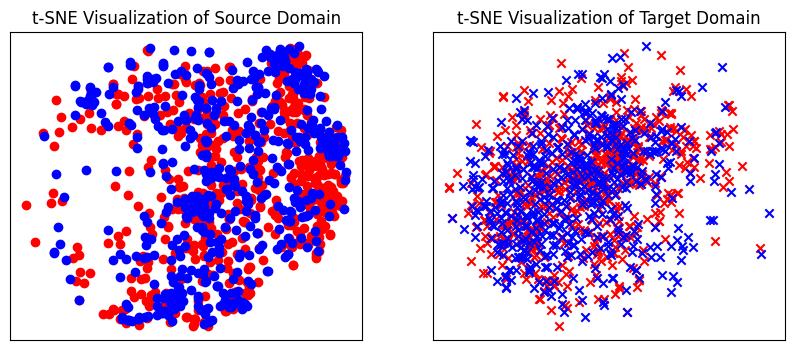

In [ ]:
def tsne_visulization(source_data: np.ndarray, target_data: np.ndarray, path: str, format: str = 'jpg'):
    s = source_data.copy()
    t = target_data.copy()
    s = s.reshape(source_data.shape[0], -1)
    t = t.reshape(target_data.shape[0], -1)
    print(s.shape, t.shape)
    combined_dataset = np.vstack((s, t))
    print(combined_dataset.shape)

    perplexity = 30
    n_dimensions = 2

    tsne = TSNE(n_components=n_dimensions, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(combined_dataset)
    tsne_source_data = tsne_result[:s.shape[0]]
    tsne_target_data = tsne_result[s.shape[0]:]
    print(tsne_source_data.shape, tsne_target_data.shape)

    source_data_class0 = tsne_source_data[source_class0_index]
    source_data_class1 = tsne_source_data[source_class1_index]
    target_data_class0 = tsne_target_data[target_class0_index]
    target_data_class1 = tsne_target_data[target_class1_index]
    print(source_data_class0.shape, source_data_class1.shape, target_data_class0.shape, target_data_class1.shape)


    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.scatter(source_data_class0[:, 0], source_data_class0[:, 1], c='r', marker='o', label='source domain class 0')
    plt.scatter(source_data_class1[:, 0], source_data_class1[:, 1], c='b', marker='o', label='source domain class 1')
    plt.title('t-SNE Visualization of Source Domain')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()

    plt.subplot(122)
    plt.scatter(target_data_class0[:, 0], target_data_class0[:, 1], c='r', marker='x', label='target domain class 0')
    plt.scatter(target_data_class1[:, 0], target_data_class1[:, 1], c='b', marker='x', label='target domain class 1')
    plt.title('t-SNE Visualization of Target Domain')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()

    path = path + '.' + format
    plt.savefig(path, format=format)
    plt.show()

tsne_visulization(source_data.numpy(), val_data.numpy(), path='test.eps')

## 3.2 without DA

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 1/500 [00:00<01:26,  5.76it/s]

Model saved at epoch 1 with validation accuracy: 0.4889
test accuracy is 0.5


  0%|          | 2/500 [00:00<01:22,  6.07it/s]

Model saved at epoch 2 with validation accuracy: 0.5111
test accuracy is 0.5
Model saved at epoch 3 with validation accuracy: 0.6222
test accuracy is 0.5


  1%|          | 3/500 [00:00<01:23,  5.96it/s]

Model saved at epoch 4 with validation accuracy: 0.8778


  1%|          | 4/500 [00:00<01:21,  6.05it/s]

test accuracy is 0.5555555555555556


  1%|          | 5/500 [00:00<01:12,  6.85it/s]

Model saved at epoch 5 with validation accuracy: 0.9000
test accuracy is 0.5398148148148149


  1%|          | 6/500 [00:00<01:11,  6.87it/s]

Model saved at epoch 6 with validation accuracy: 0.9306
test accuracy is 0.5851851851851851


  1%|▏         | 7/500 [00:01<01:14,  6.59it/s]

Model saved at epoch 7 with validation accuracy: 0.9361
test accuracy is 0.5796296296296296


  2%|▏         | 8/500 [00:01<01:08,  7.18it/s]

Model saved at epoch 8 with validation accuracy: 0.9389
test accuracy is 0.575925925925926
Model saved at epoch 10 with validation accuracy: 0.9528


  2%|▏         | 12/500 [00:01<00:47, 10.22it/s]

test accuracy is 0.5712962962962963


 13%|█▎        | 64/500 [00:05<00:28, 15.18it/s]

Model saved at epoch 62 with validation accuracy: 0.9583
test accuracy is 0.5138888888888888


 58%|█████▊    | 292/500 [00:21<00:13, 15.59it/s]

Model saved at epoch 291 with validation accuracy: 0.9611
test accuracy is 0.38333333333333336


100%|██████████| 500/500 [00:34<00:00, 14.48it/s]


the best accuracy is:  0.9611111111111111


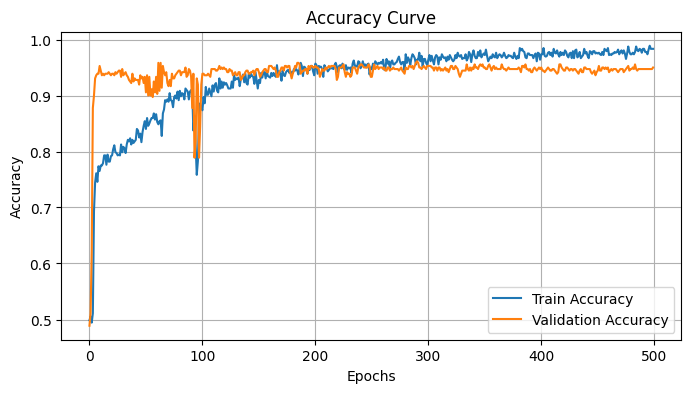

In [ ]:
def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    correct = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, features = model(x)
            correct += (torch.max(y_pred, 1)[1] == y).sum().item()

    accuracy = correct / size

    return accuracy, features



def train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=1080, epochs=500, lr=1e-3):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)
    test_dataset = TensorDataset(target_data, target_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=720, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=360, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1080, shuffle=True)

    model = EEGNet_ReLU(n_output=2)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(),lr = lr)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    model.to(DEVICE)
    # summary(model.cuda(),(1,2,750))

    loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for batch, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, source_features = model(x)

            loss = loss_fn(y_pred, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (torch.max(y_pred,1)[1] == y).sum().item()
            total += y.size(0)


        train_accuracy = correct / total
        train_accuracy_history.append(train_accuracy)

        val_accuracy, val_features = test(val_loader, model)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'EEGNet_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')
            test_acc, _ = test(test_loader, model)
            print(f'test accuracy is {test_acc}')

        val_accuracy_history.append(val_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"D_s Accuracy:",train_accuracy,"validation accuracy: ", val_accuracy, "D_t Accuracy:",test_accuracy)

    print("the best accuracy is: ", best_acc)
    model.load_state_dict(torch.load("EEGNet_best_model.pth"))
    _, source_features = model(source_data.to(DEVICE))
    _, val_features = model(val_data.to(DEVICE))
    # tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')


    plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    # plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    plt.show()



source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
val_data, val_label = source_data[-360:], source_label[-360:]
source_data, source_label = source_data[:720], source_label[:720]
# print(source_data.shape, source_label.shape)
train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=1080, epochs=500, lr=1e-1)

## 3.3 With DA

In [ ]:
def lr_lambda(epoch):
    if epoch < 100:
        return 0.1
    else:
        lr = 0.1 ** ((epoch // 100) + 1)
        return 1e-4 if lr < 1e-4 else lr


def test(data, label, model):
    model.eval()
    with torch.no_grad():
        data, label = data.to(DEVICE), label.to(DEVICE)
        pred, _, _, _ = model(data, data)

        correct_cnt = (torch.max(pred, 1)[1] == label).sum().item()
        sample_cnt = data.shape[0]
        accuracy = correct_cnt / sample_cnt

    return accuracy


def train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, batch_size=1080, epochs=500, lr=1e-3, path='test', format='jpg'):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr = lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)
    lr_scheduler = LambdaLR(optimizer, lr_lambda)


    model.to(DEVICE)

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        source_data, source_label = source_data.to(DEVICE), source_label.to(DEVICE)
        target_data = target_data.to(DEVICE)
        val_data = val_data.to(DEVICE)

        train_target_data = val_data
        train_target_data = train_target_data.to(DEVICE)

        preds, mmd_loss, source, val = model(source_data, train_target_data)

        # compute loss
        clf_loss = loss_fn(preds, source_label)
        loss = clf_loss + lambda_factor * mmd_loss

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(mmd_loss.item())

        correct_cnt = (torch.max(preds, 1)[1]== source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        val_accuracy = test(val_data, val_label, model)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'DA_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')
            print("LR: ", lr_scheduler.get_last_lr()[0], optimizer.state_dict()['param_groups'][0]['lr'])
            # if epoch > 100:
                # tsne_visulization(source.cpu().detach().numpy(), val.cpu().detach().numpy(), path='original.jpg')
        print(f'classification loss: {clf_loss.item()}, discrepency: {mmd_loss.item()}')

        if epoch == epochs - 1:
            tsne_visulization(source.cpu().detach().numpy(), val.cpu().detach().numpy(), path='original.jpg')



    print("the best accuracy is: ", best_acc)
    with torch.no_grad():
        model.load_state_dict(torch.load("DA_best_model.pth"))
        _, _, source_features, val_features = model(source_data.to(DEVICE), val_data.to(DEVICE))
        tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    # plt.show()


    plt.subplot(1, 2, 2)
    plt.plot(clf_loss_history, label="CLF Loss")
    plt.plot(mmd_loss_history, label='MMD Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()



## DDC

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 2/500 [00:00<01:53,  4.39it/s]

Model saved at epoch 1 with validation accuracy: 0.5000
LR:  0.001 0.001
classification loss: 0.6919680833816528, discrepency: 0.35134124755859375
classification loss: 0.6881908178329468, discrepency: 0.07246732711791992


  1%|          | 4/500 [00:00<01:34,  5.25it/s]

classification loss: 0.6859068870544434, discrepency: 0.044161319732666016
classification loss: 0.6835054159164429, discrepency: 0.03549623489379883


  1%|          | 6/500 [00:01<01:27,  5.64it/s]

classification loss: 0.683597207069397, discrepency: 0.01918196678161621
classification loss: 0.6835252642631531, discrepency: 0.012245893478393555


  2%|▏         | 8/500 [00:01<01:28,  5.56it/s]

Model saved at epoch 7 with validation accuracy: 0.5009
LR:  0.001 0.001
classification loss: 0.6854099631309509, discrepency: 0.010698080062866211
classification loss: 0.6850017309188843, discrepency: 0.006787538528442383


  2%|▏         | 9/500 [00:01<01:26,  5.68it/s]

classification loss: 0.684061586856842, discrepency: 0.006948709487915039
Model saved at epoch 10 with validation accuracy: 0.5019
LR:  0.001 0.001
classification loss: 0.6824464797973633, discrepency: 0.005276322364807129


  2%|▏         | 12/500 [00:02<01:25,  5.69it/s]

Model saved at epoch 11 with validation accuracy: 0.5083
LR:  0.001 0.001
classification loss: 0.6825180649757385, discrepency: 0.005253314971923828
classification loss: 0.6809176802635193, discrepency: 0.004986882209777832


  3%|▎         | 14/500 [00:02<01:23,  5.79it/s]

Model saved at epoch 13 with validation accuracy: 0.5213
LR:  0.001 0.001
classification loss: 0.6808059215545654, discrepency: 0.0028319358825683594
Model saved at epoch 14 with validation accuracy: 0.5454
LR:  0.001 0.001
classification loss: 0.6813819408416748, discrepency: 0.0027486085891723633


  3%|▎         | 16/500 [00:02<01:22,  5.87it/s]

Model saved at epoch 15 with validation accuracy: 0.5796
LR:  0.001 0.001
classification loss: 0.680298388004303, discrepency: 0.0024646520614624023
Model saved at epoch 16 with validation accuracy: 0.6028
LR:  0.001 0.001
classification loss: 0.6790479421615601, discrepency: 0.0016669034957885742


  4%|▎         | 18/500 [00:03<01:19,  6.05it/s]

classification loss: 0.6771888732910156, discrepency: 0.003569960594177246
classification loss: 0.6761565804481506, discrepency: 0.002642393112182617


  4%|▍         | 20/500 [00:03<01:18,  6.12it/s]

classification loss: 0.6733859777450562, discrepency: 0.0024154186248779297
classification loss: 0.6715924143791199, discrepency: 0.001301884651184082


  4%|▍         | 22/500 [00:03<01:17,  6.17it/s]

classification loss: 0.6706722378730774, discrepency: 0.0028290748596191406
classification loss: 0.6695727109909058, discrepency: 0.002522110939025879


  5%|▍         | 24/500 [00:04<01:17,  6.17it/s]

classification loss: 0.665240466594696, discrepency: 0.002300739288330078
classification loss: 0.6665647029876709, discrepency: 0.00164031982421875


  5%|▌         | 26/500 [00:04<01:17,  6.15it/s]

classification loss: 0.6639918088912964, discrepency: 0.0019093155860900879
classification loss: 0.6615149974822998, discrepency: 0.002315044403076172


  6%|▌         | 28/500 [00:04<01:17,  6.13it/s]

classification loss: 0.6583001017570496, discrepency: 0.0017139911651611328
classification loss: 0.6565691232681274, discrepency: 0.001535654067993164


  6%|▌         | 30/500 [00:05<01:16,  6.17it/s]

classification loss: 0.655553936958313, discrepency: 0.0013332366943359375
classification loss: 0.6506953239440918, discrepency: 0.0015712380409240723


  6%|▋         | 32/500 [00:05<01:16,  6.14it/s]

classification loss: 0.649346649646759, discrepency: 0.0015445351600646973
classification loss: 0.6452246904373169, discrepency: 0.0012627840042114258


  7%|▋         | 34/500 [00:05<01:15,  6.16it/s]

classification loss: 0.6405231356620789, discrepency: 0.0010379552841186523
classification loss: 0.6368959546089172, discrepency: 0.0012450218200683594


  7%|▋         | 36/500 [00:06<01:15,  6.16it/s]

classification loss: 0.6324605941772461, discrepency: 0.0013598203659057617
classification loss: 0.626549243927002, discrepency: 0.0015377998352050781


  8%|▊         | 38/500 [00:06<01:14,  6.16it/s]

classification loss: 0.6227477192878723, discrepency: 0.0018477439880371094
classification loss: 0.6172088384628296, discrepency: 0.0010596513748168945


  8%|▊         | 40/500 [00:06<01:14,  6.15it/s]

classification loss: 0.6105547547340393, discrepency: 0.0017386674880981445
classification loss: 0.6036088466644287, discrepency: 0.002014636993408203


  8%|▊         | 42/500 [00:07<01:14,  6.16it/s]

classification loss: 0.5991988778114319, discrepency: 0.003036022186279297
classification loss: 0.5898227691650391, discrepency: 0.0015255212783813477


  9%|▉         | 44/500 [00:07<01:14,  6.16it/s]

classification loss: 0.5838667154312134, discrepency: 0.001735687255859375
classification loss: 0.5733974575996399, discrepency: 0.0016758441925048828


  9%|▉         | 46/500 [00:07<01:14,  6.12it/s]

classification loss: 0.5665202736854553, discrepency: 0.0029168128967285156
classification loss: 0.559678852558136, discrepency: 0.002565622329711914


 10%|▉         | 48/500 [00:08<01:13,  6.11it/s]

classification loss: 0.549872636795044, discrepency: 0.002949953079223633
classification loss: 0.5444191098213196, discrepency: 0.0018298625946044922


 10%|█         | 50/500 [00:08<01:13,  6.13it/s]

classification loss: 0.5323704481124878, discrepency: 0.0073893070220947266
classification loss: 0.5269704461097717, discrepency: 0.005784511566162109


 10%|█         | 52/500 [00:08<01:13,  6.12it/s]

classification loss: 0.5244843363761902, discrepency: 0.0029287338256835938
classification loss: 0.5144903659820557, discrepency: 0.004536151885986328


 11%|█         | 54/500 [00:09<01:12,  6.14it/s]

classification loss: 0.5083163976669312, discrepency: 0.00495147705078125
classification loss: 0.5050893425941467, discrepency: 0.004602909088134766


 11%|█         | 56/500 [00:09<01:12,  6.14it/s]

classification loss: 0.4976934790611267, discrepency: 0.003981590270996094
classification loss: 0.49501562118530273, discrepency: 0.0060272216796875


 12%|█▏        | 58/500 [00:09<01:11,  6.16it/s]

classification loss: 0.4876118302345276, discrepency: 0.0037794113159179688
classification loss: 0.48438912630081177, discrepency: 0.005640506744384766


 12%|█▏        | 60/500 [00:10<01:11,  6.17it/s]

classification loss: 0.4783632159233093, discrepency: 0.0051555633544921875
classification loss: 0.47239255905151367, discrepency: 0.005043983459472656


 12%|█▏        | 62/500 [00:10<01:11,  6.16it/s]

classification loss: 0.46253761649131775, discrepency: 0.005059242248535156
classification loss: 0.459535151720047, discrepency: 0.00397491455078125


 13%|█▎        | 64/500 [00:10<01:10,  6.16it/s]

classification loss: 0.45981156826019287, discrepency: 0.007905960083007812
classification loss: 0.45099353790283203, discrepency: 0.0075016021728515625


 13%|█▎        | 66/500 [00:11<01:10,  6.14it/s]

classification loss: 0.4529742896556854, discrepency: 0.006098747253417969
classification loss: 0.44553568959236145, discrepency: 0.007887840270996094


 14%|█▎        | 68/500 [00:11<01:09,  6.18it/s]

classification loss: 0.44717925786972046, discrepency: 0.0058650970458984375
classification loss: 0.4426194131374359, discrepency: 0.005982398986816406


 14%|█▍        | 70/500 [00:11<01:09,  6.14it/s]

classification loss: 0.4368608891963959, discrepency: 0.005419731140136719
classification loss: 0.4360612630844116, discrepency: 0.0042629241943359375


 14%|█▍        | 72/500 [00:12<01:10,  6.11it/s]

classification loss: 0.43106982111930847, discrepency: 0.0058765411376953125
classification loss: 0.4332607686519623, discrepency: 0.00711822509765625


 15%|█▍        | 74/500 [00:12<01:10,  6.04it/s]

classification loss: 0.42046335339546204, discrepency: 0.0073795318603515625
classification loss: 0.4334993064403534, discrepency: 0.0046634674072265625


 15%|█▌        | 76/500 [00:12<01:10,  6.05it/s]

classification loss: 0.4250729978084564, discrepency: 0.006198883056640625
classification loss: 0.41987404227256775, discrepency: 0.002902984619140625


 16%|█▌        | 78/500 [00:13<01:10,  6.03it/s]

classification loss: 0.4213939607143402, discrepency: 0.0020923614501953125
classification loss: 0.41910654306411743, discrepency: 0.004627227783203125


 16%|█▌        | 80/500 [00:13<01:09,  6.00it/s]

Model saved at epoch 79 with validation accuracy: 0.6037
LR:  0.001 0.001
classification loss: 0.41564875841140747, discrepency: 0.0065937042236328125
classification loss: 0.4141407608985901, discrepency: 0.00296783447265625


 16%|█▋        | 82/500 [00:13<01:11,  5.83it/s]

classification loss: 0.42126649618148804, discrepency: 0.0031871795654296875
classification loss: 0.41402897238731384, discrepency: 0.0054569244384765625


 17%|█▋        | 84/500 [00:14<01:12,  5.76it/s]

classification loss: 0.4117032289505005, discrepency: 0.003498077392578125
classification loss: 0.4164257049560547, discrepency: 0.010641098022460938


 17%|█▋        | 86/500 [00:14<01:10,  5.87it/s]

classification loss: 0.4152012765407562, discrepency: 0.0024738311767578125
classification loss: 0.4084242880344391, discrepency: 0.0019474029541015625


 18%|█▊        | 88/500 [00:14<01:09,  5.90it/s]

classification loss: 0.40466436743736267, discrepency: 0.010446548461914062
classification loss: 0.40810462832450867, discrepency: 0.0042896270751953125


 18%|█▊        | 90/500 [00:15<01:09,  5.90it/s]

classification loss: 0.40864330530166626, discrepency: 0.00524139404296875
Model saved at epoch 90 with validation accuracy: 0.6046
LR:  0.001 0.001
classification loss: 0.40839117765426636, discrepency: 0.0059680938720703125


 18%|█▊        | 92/500 [00:15<01:08,  5.98it/s]

classification loss: 0.40476879477500916, discrepency: 0.0020503997802734375
classification loss: 0.404969185590744, discrepency: 0.0032596588134765625


 19%|█▉        | 94/500 [00:15<01:07,  6.02it/s]

classification loss: 0.4107646942138672, discrepency: 0.0034313201904296875
classification loss: 0.4017542600631714, discrepency: 0.003936767578125


 19%|█▉        | 96/500 [00:16<01:06,  6.06it/s]

classification loss: 0.4076499044895172, discrepency: 0.00244903564453125
classification loss: 0.3986053466796875, discrepency: 0.00583648681640625


 20%|█▉        | 98/500 [00:16<01:06,  6.04it/s]

classification loss: 0.4032374620437622, discrepency: 0.001338958740234375
classification loss: 0.39968928694725037, discrepency: 0.0026493072509765625


 20%|██        | 100/500 [00:16<01:06,  6.05it/s]

classification loss: 0.39656510949134827, discrepency: 0.00405120849609375
classification loss: 0.40131035447120667, discrepency: 0.0040454864501953125


 20%|██        | 102/500 [00:17<01:05,  6.06it/s]

classification loss: 0.40766459703445435, discrepency: 0.0027675628662109375
classification loss: 0.39903944730758667, discrepency: 0.006381988525390625


 21%|██        | 104/500 [00:17<01:05,  6.07it/s]

classification loss: 0.40001434087753296, discrepency: 0.0062160491943359375
classification loss: 0.3965145945549011, discrepency: 0.0026187896728515625


 21%|██        | 106/500 [00:17<01:05,  6.02it/s]

classification loss: 0.3981502652168274, discrepency: 0.00316619873046875
classification loss: 0.40938901901245117, discrepency: 0.00235748291015625


 22%|██▏       | 108/500 [00:18<01:05,  6.03it/s]

classification loss: 0.3908752202987671, discrepency: 0.00113677978515625
classification loss: 0.39233431220054626, discrepency: 0.00119781494140625


 22%|██▏       | 110/500 [00:18<01:04,  6.03it/s]

classification loss: 0.3963564336299896, discrepency: 0.002216339111328125
classification loss: 0.3983438014984131, discrepency: 0.001827239990234375


 22%|██▏       | 112/500 [00:18<01:04,  6.03it/s]

classification loss: 0.4010075330734253, discrepency: 0.001926422119140625
classification loss: 0.3962949812412262, discrepency: 0.0008296966552734375


 23%|██▎       | 114/500 [00:19<01:03,  6.04it/s]

classification loss: 0.3967723846435547, discrepency: 0.00189971923828125
classification loss: 0.3986451029777527, discrepency: 0.001773834228515625


 23%|██▎       | 116/500 [00:19<01:03,  6.01it/s]

classification loss: 0.3968564569950104, discrepency: 0.00135040283203125
classification loss: 0.4092470407485962, discrepency: 0.0017604827880859375


 24%|██▎       | 118/500 [00:19<01:03,  6.00it/s]

classification loss: 0.39979320764541626, discrepency: 0.0011653900146484375
classification loss: 0.3983606696128845, discrepency: 0.002666473388671875


 24%|██▍       | 120/500 [00:20<01:03,  6.01it/s]

classification loss: 0.40246742963790894, discrepency: 0.002246856689453125
classification loss: 0.39653587341308594, discrepency: 0.0029239654541015625


 24%|██▍       | 122/500 [00:20<01:02,  6.03it/s]

classification loss: 0.3928079903125763, discrepency: 0.0021724700927734375
classification loss: 0.39841797947883606, discrepency: 0.0023021697998046875


 25%|██▍       | 124/500 [00:20<01:02,  6.03it/s]

classification loss: 0.39432621002197266, discrepency: 0.001384735107421875
classification loss: 0.3935467302799225, discrepency: 0.0020313262939453125


 25%|██▌       | 126/500 [00:21<01:02,  6.03it/s]

classification loss: 0.39554253220558167, discrepency: 0.0022716522216796875
classification loss: 0.3902336359024048, discrepency: 0.00092315673828125


 26%|██▌       | 128/500 [00:21<01:01,  6.03it/s]

classification loss: 0.39092835783958435, discrepency: 0.0012874603271484375
classification loss: 0.3975358009338379, discrepency: 0.0012264251708984375


 26%|██▌       | 130/500 [00:21<01:00,  6.08it/s]

classification loss: 0.3951028883457184, discrepency: 0.0021209716796875
classification loss: 0.39934828877449036, discrepency: 0.0009593963623046875


 26%|██▋       | 132/500 [00:22<01:00,  6.10it/s]

classification loss: 0.4039876461029053, discrepency: 0.0017261505126953125
classification loss: 0.3895761966705322, discrepency: 0.0008563995361328125


 27%|██▋       | 134/500 [00:22<00:59,  6.11it/s]

classification loss: 0.38814252614974976, discrepency: 0.002040863037109375
classification loss: 0.38924381136894226, discrepency: 0.0011348724365234375


 27%|██▋       | 136/500 [00:22<00:59,  6.10it/s]

classification loss: 0.39820101857185364, discrepency: 0.0013580322265625
classification loss: 0.3942897617816925, discrepency: 0.001255035400390625


 28%|██▊       | 138/500 [00:22<00:59,  6.08it/s]

classification loss: 0.39462417364120483, discrepency: 0.000736236572265625
classification loss: 0.39359965920448303, discrepency: 0.0013713836669921875


 28%|██▊       | 140/500 [00:23<00:59,  6.07it/s]

classification loss: 0.39267462491989136, discrepency: 0.00112152099609375
classification loss: 0.39619970321655273, discrepency: 0.0009002685546875


 28%|██▊       | 142/500 [00:23<00:58,  6.08it/s]

classification loss: 0.39061981439590454, discrepency: 0.0006084442138671875
classification loss: 0.3914252817630768, discrepency: 0.00104522705078125


 29%|██▉       | 144/500 [00:23<00:58,  6.09it/s]

classification loss: 0.3928259015083313, discrepency: 0.0008144378662109375
classification loss: 0.3962915539741516, discrepency: 0.001041412353515625


 29%|██▉       | 146/500 [00:24<00:58,  6.03it/s]

classification loss: 0.39278316497802734, discrepency: 0.0013828277587890625
classification loss: 0.40044254064559937, discrepency: 0.0011997222900390625


 30%|██▉       | 148/500 [00:24<00:58,  6.05it/s]

classification loss: 0.39633116126060486, discrepency: 0.0014209747314453125
classification loss: 0.39815059304237366, discrepency: 0.001201629638671875


 30%|███       | 150/500 [00:24<00:57,  6.08it/s]

classification loss: 0.39728277921676636, discrepency: 0.0016193389892578125
classification loss: 0.4006709158420563, discrepency: 0.0032482147216796875


 30%|███       | 152/500 [00:25<00:57,  6.09it/s]

classification loss: 0.3948231637477875, discrepency: 0.002231597900390625
classification loss: 0.40470799803733826, discrepency: 0.0012798309326171875


 31%|███       | 154/500 [00:25<00:56,  6.07it/s]

classification loss: 0.39862626791000366, discrepency: 0.0014095306396484375
classification loss: 0.39461997151374817, discrepency: 0.00144195556640625


 31%|███       | 156/500 [00:25<00:56,  6.04it/s]

classification loss: 0.39333534240722656, discrepency: 0.0010986328125
classification loss: 0.39411357045173645, discrepency: 0.001712799072265625


 32%|███▏      | 158/500 [00:26<00:56,  6.08it/s]

classification loss: 0.3955588936805725, discrepency: 0.0012683868408203125
classification loss: 0.39543312788009644, discrepency: 0.001682281494140625


 32%|███▏      | 160/500 [00:26<00:55,  6.09it/s]

classification loss: 0.39238056540489197, discrepency: 0.0022487640380859375
classification loss: 0.39413002133369446, discrepency: 0.00311279296875


 32%|███▏      | 162/500 [00:26<00:55,  6.06it/s]

classification loss: 0.39412832260131836, discrepency: 0.00064849853515625
classification loss: 0.4008088707923889, discrepency: 0.0020294189453125


 33%|███▎      | 164/500 [00:27<00:55,  6.05it/s]

classification loss: 0.397722452878952, discrepency: 0.001190185546875
classification loss: 0.3955118954181671, discrepency: 0.001407623291015625


 33%|███▎      | 166/500 [00:27<00:55,  6.07it/s]

classification loss: 0.3999209403991699, discrepency: 0.0027675628662109375
classification loss: 0.39210036396980286, discrepency: 0.0014820098876953125


 34%|███▎      | 168/500 [00:27<00:54,  6.08it/s]

classification loss: 0.39540430903434753, discrepency: 0.0023365020751953125
classification loss: 0.3974868059158325, discrepency: 0.003330230712890625


 34%|███▍      | 170/500 [00:28<00:54,  6.04it/s]

classification loss: 0.3929803967475891, discrepency: 0.0022907257080078125
classification loss: 0.39503735303878784, discrepency: 0.001026153564453125


 34%|███▍      | 172/500 [00:28<00:54,  6.06it/s]

classification loss: 0.39023035764694214, discrepency: 0.001689910888671875
classification loss: 0.39361336827278137, discrepency: 0.0018768310546875


 35%|███▍      | 174/500 [00:28<00:53,  6.08it/s]

classification loss: 0.39224836230278015, discrepency: 0.001087188720703125
classification loss: 0.3984094560146332, discrepency: 0.0006771087646484375


 35%|███▌      | 176/500 [00:29<00:53,  6.07it/s]

classification loss: 0.397263765335083, discrepency: 0.0005054473876953125
classification loss: 0.39355847239494324, discrepency: 0.0006885528564453125


 36%|███▌      | 178/500 [00:29<00:53,  6.04it/s]

classification loss: 0.39767763018608093, discrepency: 0.000827789306640625
classification loss: 0.39270177483558655, discrepency: 0.0017032623291015625


 36%|███▌      | 180/500 [00:29<00:52,  6.05it/s]

classification loss: 0.3979838788509369, discrepency: 0.0017604827880859375
classification loss: 0.38975438475608826, discrepency: 0.0011005401611328125


 36%|███▋      | 182/500 [00:30<00:52,  6.05it/s]

classification loss: 0.39226865768432617, discrepency: 0.00188446044921875
classification loss: 0.4007777273654938, discrepency: 0.00142669677734375


 37%|███▋      | 184/500 [00:30<00:52,  6.03it/s]

classification loss: 0.3894358277320862, discrepency: 0.0014667510986328125
classification loss: 0.3941294848918915, discrepency: 0.0006046295166015625


 37%|███▋      | 186/500 [00:30<00:52,  6.03it/s]

classification loss: 0.39050325751304626, discrepency: 0.00298309326171875
classification loss: 0.3925248384475708, discrepency: 0.0029201507568359375


 38%|███▊      | 188/500 [00:31<00:51,  6.01it/s]

classification loss: 0.38995832204818726, discrepency: 0.001659393310546875
classification loss: 0.3971637785434723, discrepency: 0.0020656585693359375


 38%|███▊      | 190/500 [00:31<00:51,  6.00it/s]

classification loss: 0.3916051983833313, discrepency: 0.0017547607421875
classification loss: 0.38818246126174927, discrepency: 0.0017795562744140625


 38%|███▊      | 192/500 [00:31<00:51,  5.97it/s]

classification loss: 0.3942529261112213, discrepency: 0.001861572265625
classification loss: 0.3870599865913391, discrepency: 0.0016345977783203125


 39%|███▉      | 194/500 [00:32<00:51,  5.97it/s]

classification loss: 0.39099910855293274, discrepency: 0.0020694732666015625
classification loss: 0.39412838220596313, discrepency: 0.00091552734375


 39%|███▉      | 196/500 [00:32<00:50,  5.99it/s]

classification loss: 0.39363452792167664, discrepency: 0.001529693603515625
classification loss: 0.39867886900901794, discrepency: 0.002040863037109375


 40%|███▉      | 198/500 [00:32<00:50,  5.95it/s]

classification loss: 0.3930744230747223, discrepency: 0.0015239715576171875
classification loss: 0.3847746253013611, discrepency: 0.0012912750244140625


 40%|████      | 200/500 [00:33<00:50,  5.98it/s]

classification loss: 0.3881036937236786, discrepency: 0.0012874603271484375
classification loss: 0.3923480212688446, discrepency: 0.0038604736328125


 40%|████      | 202/500 [00:33<00:50,  5.94it/s]

classification loss: 0.3939644694328308, discrepency: 0.0012359619140625
classification loss: 0.3918844163417816, discrepency: 0.0025482177734375


 41%|████      | 204/500 [00:33<00:49,  5.98it/s]

classification loss: 0.39333468675613403, discrepency: 0.0023021697998046875
classification loss: 0.38399696350097656, discrepency: 0.0012607574462890625


 41%|████      | 206/500 [00:34<00:49,  5.97it/s]

classification loss: 0.3965016007423401, discrepency: 0.001369476318359375
classification loss: 0.39406096935272217, discrepency: 0.0011386871337890625


 42%|████▏     | 208/500 [00:34<00:48,  5.98it/s]

classification loss: 0.393573522567749, discrepency: 0.00128936767578125
classification loss: 0.39057886600494385, discrepency: 0.00104522705078125


 42%|████▏     | 210/500 [00:34<00:48,  5.97it/s]

classification loss: 0.3940383791923523, discrepency: 0.0017795562744140625
classification loss: 0.38996076583862305, discrepency: 0.001277923583984375


 42%|████▏     | 212/500 [00:35<00:48,  5.98it/s]

classification loss: 0.39013829827308655, discrepency: 0.0011234283447265625
classification loss: 0.38890522718429565, discrepency: 0.000705718994140625


 43%|████▎     | 214/500 [00:35<00:48,  5.94it/s]

classification loss: 0.3947208523750305, discrepency: 0.000644683837890625
classification loss: 0.3937841057777405, discrepency: 0.001499176025390625


 43%|████▎     | 216/500 [00:35<00:47,  5.97it/s]

classification loss: 0.3944595754146576, discrepency: 0.00177764892578125
classification loss: 0.39444106817245483, discrepency: 0.0011844635009765625


 44%|████▎     | 218/500 [00:36<00:47,  5.94it/s]

classification loss: 0.39392969012260437, discrepency: 0.00052642822265625
classification loss: 0.39171159267425537, discrepency: 0.0006866455078125


 44%|████▍     | 220/500 [00:36<00:47,  5.89it/s]

classification loss: 0.39221400022506714, discrepency: 0.0013523101806640625
classification loss: 0.38883277773857117, discrepency: 0.001338958740234375


 44%|████▍     | 222/500 [00:36<00:46,  5.98it/s]

classification loss: 0.40123674273490906, discrepency: 0.00179290771484375
classification loss: 0.39469900727272034, discrepency: 0.0013103485107421875


 45%|████▍     | 224/500 [00:37<00:46,  5.98it/s]

classification loss: 0.39408132433891296, discrepency: 0.00084686279296875
classification loss: 0.39530909061431885, discrepency: 0.0013141632080078125


 45%|████▌     | 226/500 [00:37<00:45,  6.00it/s]

classification loss: 0.3883432149887085, discrepency: 0.0016574859619140625
classification loss: 0.39044296741485596, discrepency: 0.0015850067138671875


 46%|████▌     | 228/500 [00:37<00:45,  6.04it/s]

classification loss: 0.3957454562187195, discrepency: 0.0012969970703125
classification loss: 0.3936172127723694, discrepency: 0.000972747802734375


 46%|████▌     | 230/500 [00:38<00:44,  6.03it/s]

classification loss: 0.393485963344574, discrepency: 0.0007266998291015625
classification loss: 0.3935139775276184, discrepency: 0.001224517822265625


 46%|████▋     | 232/500 [00:38<00:44,  6.00it/s]

classification loss: 0.39566028118133545, discrepency: 0.0016269683837890625
classification loss: 0.39416947960853577, discrepency: 0.00130462646484375


 47%|████▋     | 234/500 [00:38<00:43,  6.07it/s]

classification loss: 0.3880736529827118, discrepency: 0.0010852813720703125
classification loss: 0.38574305176734924, discrepency: 0.001377105712890625


 47%|████▋     | 236/500 [00:39<00:43,  6.06it/s]

classification loss: 0.3905145227909088, discrepency: 0.0009136199951171875
classification loss: 0.3902656137943268, discrepency: 0.00080108642578125


 48%|████▊     | 238/500 [00:39<00:43,  6.04it/s]

classification loss: 0.38494953513145447, discrepency: 0.003131866455078125
classification loss: 0.3908478617668152, discrepency: 0.0019779205322265625


 48%|████▊     | 240/500 [00:39<00:43,  6.04it/s]

classification loss: 0.3910249173641205, discrepency: 0.0003108978271484375
classification loss: 0.3885960280895233, discrepency: 0.0011730194091796875


 48%|████▊     | 242/500 [00:40<00:42,  6.03it/s]

classification loss: 0.3901531994342804, discrepency: 0.0009860992431640625
classification loss: 0.39195942878723145, discrepency: 0.0017261505126953125


 49%|████▉     | 244/500 [00:40<00:42,  6.02it/s]

classification loss: 0.39710596203804016, discrepency: 0.0018177032470703125
classification loss: 0.3946762681007385, discrepency: 0.0007915496826171875


 49%|████▉     | 246/500 [00:40<00:42,  6.03it/s]

classification loss: 0.39804625511169434, discrepency: 0.000995635986328125
classification loss: 0.39534440636634827, discrepency: 0.0014190673828125


 50%|████▉     | 248/500 [00:41<00:41,  6.02it/s]

classification loss: 0.39429986476898193, discrepency: 0.00089263916015625
classification loss: 0.3966543674468994, discrepency: 0.002094268798828125


 50%|█████     | 250/500 [00:41<00:41,  6.03it/s]

classification loss: 0.38532254099845886, discrepency: 0.001224517822265625
classification loss: 0.39058998227119446, discrepency: 0.0010471343994140625


 50%|█████     | 252/500 [00:41<00:40,  6.07it/s]

classification loss: 0.38986533880233765, discrepency: 0.00164794921875
classification loss: 0.3886944353580475, discrepency: 0.0016956329345703125


 51%|█████     | 254/500 [00:42<00:40,  6.04it/s]

classification loss: 0.38901373744010925, discrepency: 0.0017986297607421875
classification loss: 0.3907073736190796, discrepency: 0.0013942718505859375


 51%|█████     | 256/500 [00:42<00:40,  6.03it/s]

classification loss: 0.3908158838748932, discrepency: 0.0010852813720703125
classification loss: 0.39637652039527893, discrepency: 0.0011310577392578125


 52%|█████▏    | 258/500 [00:42<00:39,  6.06it/s]

classification loss: 0.3918699324131012, discrepency: 0.0013027191162109375
classification loss: 0.39101293683052063, discrepency: 0.0011444091796875


 52%|█████▏    | 260/500 [00:43<00:39,  6.03it/s]

classification loss: 0.3933010697364807, discrepency: 0.001567840576171875
classification loss: 0.3942590057849884, discrepency: 0.0018138885498046875


 52%|█████▏    | 262/500 [00:43<00:39,  6.00it/s]

classification loss: 0.38643118739128113, discrepency: 0.000629425048828125
classification loss: 0.38965922594070435, discrepency: 0.0007114410400390625


 53%|█████▎    | 264/500 [00:43<00:39,  5.99it/s]

classification loss: 0.3874707520008087, discrepency: 0.000591278076171875
classification loss: 0.3988540470600128, discrepency: 0.0011196136474609375


 53%|█████▎    | 266/500 [00:44<00:39,  6.00it/s]

classification loss: 0.3943607807159424, discrepency: 0.000579833984375
classification loss: 0.38872382044792175, discrepency: 0.0007724761962890625


 54%|█████▎    | 268/500 [00:44<00:38,  6.04it/s]

classification loss: 0.3911098837852478, discrepency: 0.001056671142578125
classification loss: 0.39459890127182007, discrepency: 0.0013599395751953125


 54%|█████▍    | 270/500 [00:44<00:38,  6.00it/s]

classification loss: 0.38938191533088684, discrepency: 0.0008144378662109375
classification loss: 0.3910123407840729, discrepency: 0.0014553070068359375


 54%|█████▍    | 272/500 [00:45<00:37,  6.04it/s]

classification loss: 0.38985323905944824, discrepency: 0.001506805419921875
classification loss: 0.3925154209136963, discrepency: 0.0029811859130859375


 55%|█████▍    | 274/500 [00:45<00:37,  5.98it/s]

classification loss: 0.38695207238197327, discrepency: 0.0014743804931640625
classification loss: 0.3894023895263672, discrepency: 0.001148223876953125


 55%|█████▌    | 276/500 [00:45<00:37,  6.02it/s]

classification loss: 0.3943555951118469, discrepency: 0.0005855560302734375
classification loss: 0.39335954189300537, discrepency: 0.001056671142578125


 56%|█████▌    | 278/500 [00:46<00:37,  5.96it/s]

classification loss: 0.3982771039009094, discrepency: 0.000545501708984375
classification loss: 0.39218467473983765, discrepency: 0.000698089599609375


 56%|█████▌    | 280/500 [00:46<00:36,  6.02it/s]

classification loss: 0.3926313519477844, discrepency: 0.00182342529296875
classification loss: 0.39565399289131165, discrepency: 0.00063323974609375


 56%|█████▋    | 282/500 [00:46<00:36,  5.97it/s]

classification loss: 0.39272427558898926, discrepency: 0.0021114349365234375
classification loss: 0.39240291714668274, discrepency: 0.0019512176513671875


 57%|█████▋    | 284/500 [00:47<00:35,  6.02it/s]

classification loss: 0.38681674003601074, discrepency: 0.0018672943115234375
classification loss: 0.38650235533714294, discrepency: 0.002117156982421875


 57%|█████▋    | 286/500 [00:47<00:36,  5.94it/s]

classification loss: 0.3900473117828369, discrepency: 0.0011501312255859375
classification loss: 0.39129722118377686, discrepency: 0.0013751983642578125


 58%|█████▊    | 288/500 [00:47<00:35,  5.96it/s]

classification loss: 0.38851672410964966, discrepency: 0.0008907318115234375
classification loss: 0.3853069543838501, discrepency: 0.0008029937744140625


 58%|█████▊    | 290/500 [00:48<00:35,  5.95it/s]

classification loss: 0.3873633146286011, discrepency: 0.0007762908935546875
classification loss: 0.39470210671424866, discrepency: 0.0009021759033203125


 58%|█████▊    | 292/500 [00:48<00:34,  5.97it/s]

classification loss: 0.38636118173599243, discrepency: 0.001995086669921875
classification loss: 0.3854529559612274, discrepency: 0.001018524169921875


 59%|█████▉    | 294/500 [00:48<00:34,  5.97it/s]

classification loss: 0.38922935724258423, discrepency: 0.0006275177001953125
classification loss: 0.3947105407714844, discrepency: 0.0009918212890625


 59%|█████▉    | 296/500 [00:49<00:33,  6.04it/s]

classification loss: 0.391811341047287, discrepency: 0.0018253326416015625
classification loss: 0.3879855275154114, discrepency: 0.0008716583251953125


 60%|█████▉    | 298/500 [00:49<00:33,  6.04it/s]

classification loss: 0.3862145245075226, discrepency: 0.0012969970703125
classification loss: 0.3912334740161896, discrepency: 0.0006103515625


 60%|██████    | 300/500 [00:49<00:33,  6.03it/s]

classification loss: 0.3886983394622803, discrepency: 0.0012607574462890625
classification loss: 0.3935837149620056, discrepency: 0.0005168914794921875


 60%|██████    | 302/500 [00:50<00:32,  6.08it/s]

classification loss: 0.3835068941116333, discrepency: 0.00200653076171875
classification loss: 0.3865053951740265, discrepency: 0.0012454986572265625


 61%|██████    | 304/500 [00:50<00:32,  6.05it/s]

classification loss: 0.39268943667411804, discrepency: 0.0008602142333984375
classification loss: 0.3965160548686981, discrepency: 0.0007572174072265625


 61%|██████    | 306/500 [00:50<00:32,  5.99it/s]

classification loss: 0.3985403776168823, discrepency: 0.0015087127685546875
classification loss: 0.38932517170906067, discrepency: 0.0011768341064453125


 62%|██████▏   | 308/500 [00:51<00:32,  5.95it/s]

classification loss: 0.39437010884284973, discrepency: 0.0015277862548828125
classification loss: 0.38405641913414, discrepency: 0.003688812255859375


 62%|██████▏   | 310/500 [00:51<00:31,  6.00it/s]

classification loss: 0.3921181857585907, discrepency: 0.0017108917236328125
classification loss: 0.3871290385723114, discrepency: 0.0005741119384765625


 62%|██████▏   | 312/500 [00:51<00:31,  6.01it/s]

classification loss: 0.393230676651001, discrepency: 0.0009860992431640625
classification loss: 0.39120379090309143, discrepency: 0.0007152557373046875


 63%|██████▎   | 314/500 [00:52<00:31,  6.00it/s]

classification loss: 0.3894811272621155, discrepency: 0.0013179779052734375
classification loss: 0.39212507009506226, discrepency: 0.0017910003662109375


 63%|██████▎   | 316/500 [00:52<00:30,  6.04it/s]

classification loss: 0.38742321729660034, discrepency: 0.0007534027099609375
classification loss: 0.3936838209629059, discrepency: 0.000911712646484375


 64%|██████▎   | 318/500 [00:52<00:29,  6.07it/s]

classification loss: 0.39005932211875916, discrepency: 0.00054931640625
classification loss: 0.3920727074146271, discrepency: 0.0006008148193359375


 64%|██████▍   | 320/500 [00:53<00:29,  6.04it/s]

classification loss: 0.39006558060646057, discrepency: 0.001377105712890625
classification loss: 0.39177677035331726, discrepency: 0.001956939697265625


 64%|██████▍   | 322/500 [00:53<00:29,  6.05it/s]

classification loss: 0.39360374212265015, discrepency: 0.00081634521484375
classification loss: 0.391707181930542, discrepency: 0.0016498565673828125


 65%|██████▍   | 324/500 [00:53<00:28,  6.09it/s]

classification loss: 0.39199909567832947, discrepency: 0.001239776611328125
classification loss: 0.3921715021133423, discrepency: 0.001232147216796875


 65%|██████▌   | 326/500 [00:54<00:28,  6.13it/s]

classification loss: 0.391639769077301, discrepency: 0.001190185546875
classification loss: 0.39710214734077454, discrepency: 0.00115203857421875


 66%|██████▌   | 328/500 [00:54<00:28,  6.08it/s]

classification loss: 0.39098677039146423, discrepency: 0.00080108642578125
classification loss: 0.3947224020957947, discrepency: 0.00090789794921875


 66%|██████▌   | 330/500 [00:54<00:28,  6.05it/s]

classification loss: 0.389830619096756, discrepency: 0.0013275146484375
classification loss: 0.3965434432029724, discrepency: 0.001861572265625


 66%|██████▋   | 332/500 [00:55<00:27,  6.07it/s]

classification loss: 0.393974244594574, discrepency: 0.0013294219970703125
classification loss: 0.3830660581588745, discrepency: 0.0008392333984375


 67%|██████▋   | 334/500 [00:55<00:27,  6.11it/s]

classification loss: 0.3928360641002655, discrepency: 0.00138092041015625
classification loss: 0.39830994606018066, discrepency: 0.0011386871337890625


 67%|██████▋   | 336/500 [00:55<00:26,  6.12it/s]

classification loss: 0.39687928557395935, discrepency: 0.001049041748046875
classification loss: 0.39924633502960205, discrepency: 0.0004558563232421875


 68%|██████▊   | 338/500 [00:56<00:26,  6.16it/s]

classification loss: 0.3944869339466095, discrepency: 0.0015544891357421875
classification loss: 0.3878155052661896, discrepency: 0.001644134521484375


 68%|██████▊   | 340/500 [00:56<00:25,  6.15it/s]

classification loss: 0.39585864543914795, discrepency: 0.001102447509765625
classification loss: 0.3878075182437897, discrepency: 0.000579833984375


 68%|██████▊   | 342/500 [00:56<00:25,  6.11it/s]

classification loss: 0.4018633961677551, discrepency: 0.00080108642578125
classification loss: 0.3889659643173218, discrepency: 0.001007080078125


 69%|██████▉   | 344/500 [00:57<00:25,  6.11it/s]

classification loss: 0.38858112692832947, discrepency: 0.0011234283447265625
classification loss: 0.39279666543006897, discrepency: 0.00099945068359375


 69%|██████▉   | 346/500 [00:57<00:25,  6.11it/s]

classification loss: 0.39236918091773987, discrepency: 0.0010166168212890625
classification loss: 0.3986309766769409, discrepency: 0.0018634796142578125


 70%|██████▉   | 348/500 [00:57<00:24,  6.10it/s]

classification loss: 0.3942621350288391, discrepency: 0.0010738372802734375
classification loss: 0.39553704857826233, discrepency: 0.001438140869140625


 70%|███████   | 350/500 [00:58<00:24,  6.12it/s]

classification loss: 0.3931661546230316, discrepency: 0.001251220703125
classification loss: 0.39130860567092896, discrepency: 0.0018520355224609375


 70%|███████   | 352/500 [00:58<00:24,  6.12it/s]

classification loss: 0.39179497957229614, discrepency: 0.002056121826171875
classification loss: 0.3907868564128876, discrepency: 0.0012416839599609375


 71%|███████   | 354/500 [00:58<00:23,  6.12it/s]

classification loss: 0.3879902958869934, discrepency: 0.0016536712646484375
classification loss: 0.3963097631931305, discrepency: 0.0020160675048828125


 71%|███████   | 356/500 [00:59<00:23,  6.14it/s]

classification loss: 0.38639602065086365, discrepency: 0.0012722015380859375
classification loss: 0.3924987018108368, discrepency: 0.0029087066650390625


 72%|███████▏  | 358/500 [00:59<00:23,  6.14it/s]

classification loss: 0.38958945870399475, discrepency: 0.0012035369873046875
classification loss: 0.39541709423065186, discrepency: 0.001129150390625


 72%|███████▏  | 360/500 [00:59<00:22,  6.12it/s]

classification loss: 0.3905058205127716, discrepency: 0.0006504058837890625
classification loss: 0.39348313212394714, discrepency: 0.000743865966796875


 72%|███████▏  | 362/500 [01:00<00:22,  6.08it/s]

classification loss: 0.3919672667980194, discrepency: 0.000652313232421875
classification loss: 0.3862771987915039, discrepency: 0.0006694793701171875


 73%|███████▎  | 364/500 [01:00<00:22,  6.08it/s]

classification loss: 0.39654573798179626, discrepency: 0.0013904571533203125
classification loss: 0.3957119286060333, discrepency: 0.000957489013671875


 73%|███████▎  | 366/500 [01:00<00:21,  6.12it/s]

classification loss: 0.39114469289779663, discrepency: 0.00113677978515625
classification loss: 0.3889639675617218, discrepency: 0.00087738037109375


 74%|███████▎  | 368/500 [01:01<00:21,  6.15it/s]

classification loss: 0.3952069878578186, discrepency: 0.0011959075927734375
classification loss: 0.39186331629753113, discrepency: 0.0013523101806640625


 74%|███████▍  | 370/500 [01:01<00:21,  6.16it/s]

classification loss: 0.393067866563797, discrepency: 0.0018558502197265625
classification loss: 0.39127275347709656, discrepency: 0.0009250640869140625


 74%|███████▍  | 372/500 [01:01<00:20,  6.16it/s]

classification loss: 0.3974936902523041, discrepency: 0.0009136199951171875
classification loss: 0.3985796570777893, discrepency: 0.0008869171142578125


 75%|███████▍  | 374/500 [01:02<00:20,  6.16it/s]

classification loss: 0.3884819746017456, discrepency: 0.0007534027099609375
classification loss: 0.39487388730049133, discrepency: 0.001041412353515625


 75%|███████▌  | 376/500 [01:02<00:20,  6.16it/s]

classification loss: 0.38934651017189026, discrepency: 0.001682281494140625
classification loss: 0.3868720829486847, discrepency: 0.001220703125


 76%|███████▌  | 378/500 [01:02<00:19,  6.13it/s]

classification loss: 0.39642027020454407, discrepency: 0.00069427490234375
classification loss: 0.40002140402793884, discrepency: 0.001850128173828125


 76%|███████▌  | 380/500 [01:03<00:19,  6.13it/s]

classification loss: 0.39170289039611816, discrepency: 0.0006504058837890625
classification loss: 0.3883996605873108, discrepency: 0.0008640289306640625


 76%|███████▋  | 382/500 [01:03<00:19,  6.13it/s]

classification loss: 0.3901272416114807, discrepency: 0.0012950897216796875
classification loss: 0.39034220576286316, discrepency: 0.0018215179443359375


 77%|███████▋  | 384/500 [01:03<00:19,  6.10it/s]

classification loss: 0.3979153335094452, discrepency: 0.00254058837890625
classification loss: 0.3941703140735626, discrepency: 0.001544952392578125


 77%|███████▋  | 386/500 [01:04<00:18,  6.09it/s]

classification loss: 0.4020175337791443, discrepency: 0.0010738372802734375
classification loss: 0.3926190137863159, discrepency: 0.001232147216796875


 78%|███████▊  | 388/500 [01:04<00:18,  6.10it/s]

classification loss: 0.3925821781158447, discrepency: 0.000827789306640625
classification loss: 0.38713356852531433, discrepency: 0.0005931854248046875


 78%|███████▊  | 390/500 [01:04<00:18,  6.09it/s]

classification loss: 0.3919738829135895, discrepency: 0.000759124755859375
classification loss: 0.38519689440727234, discrepency: 0.0014286041259765625


 78%|███████▊  | 392/500 [01:05<00:17,  6.05it/s]

classification loss: 0.39483973383903503, discrepency: 0.0009765625
classification loss: 0.4004443883895874, discrepency: 0.00066375732421875


 79%|███████▉  | 394/500 [01:05<00:17,  6.07it/s]

classification loss: 0.39321133494377136, discrepency: 0.0006580352783203125
classification loss: 0.3917611241340637, discrepency: 0.001224517822265625


 79%|███████▉  | 396/500 [01:05<00:16,  6.12it/s]

classification loss: 0.385809987783432, discrepency: 0.0009326934814453125
classification loss: 0.3838362693786621, discrepency: 0.001705169677734375


 80%|███████▉  | 398/500 [01:05<00:16,  6.12it/s]

classification loss: 0.3902878761291504, discrepency: 0.001132965087890625
classification loss: 0.3930109143257141, discrepency: 0.0007572174072265625


 80%|████████  | 400/500 [01:06<00:16,  6.10it/s]

classification loss: 0.3914789855480194, discrepency: 0.0010814666748046875
classification loss: 0.3925168216228485, discrepency: 0.0016841888427734375


 80%|████████  | 402/500 [01:06<00:16,  6.03it/s]

classification loss: 0.3918983042240143, discrepency: 0.0007171630859375
classification loss: 0.38758009672164917, discrepency: 0.0015926361083984375


 81%|████████  | 404/500 [01:06<00:15,  6.05it/s]

classification loss: 0.3923363983631134, discrepency: 0.0011196136474609375
classification loss: 0.38740527629852295, discrepency: 0.000652313232421875


 81%|████████  | 406/500 [01:07<00:15,  6.04it/s]

classification loss: 0.39050424098968506, discrepency: 0.0021877288818359375
classification loss: 0.3926391005516052, discrepency: 0.003620147705078125


 82%|████████▏ | 408/500 [01:07<00:15,  6.03it/s]

classification loss: 0.400933176279068, discrepency: 0.0006122589111328125
classification loss: 0.3911166489124298, discrepency: 0.001064300537109375


 82%|████████▏ | 410/500 [01:07<00:14,  6.06it/s]

classification loss: 0.39729347825050354, discrepency: 0.0008697509765625
classification loss: 0.39065301418304443, discrepency: 0.001556396484375


 82%|████████▏ | 412/500 [01:08<00:14,  6.10it/s]

classification loss: 0.3955267071723938, discrepency: 0.001216888427734375
classification loss: 0.3920661509037018, discrepency: 0.0014438629150390625


 83%|████████▎ | 414/500 [01:08<00:14,  6.12it/s]

classification loss: 0.39950188994407654, discrepency: 0.0010166168212890625
classification loss: 0.39125946164131165, discrepency: 0.0017032623291015625


 83%|████████▎ | 416/500 [01:08<00:13,  6.08it/s]

classification loss: 0.39236482977867126, discrepency: 0.0010223388671875
classification loss: 0.3897221088409424, discrepency: 0.0019168853759765625


 84%|████████▎ | 418/500 [01:09<00:13,  6.05it/s]

classification loss: 0.3874557912349701, discrepency: 0.0010929107666015625
classification loss: 0.3912524878978729, discrepency: 0.00057220458984375


 84%|████████▍ | 420/500 [01:09<00:13,  6.06it/s]

classification loss: 0.39328762888908386, discrepency: 0.0018367767333984375
classification loss: 0.3865523040294647, discrepency: 0.0002765655517578125


 84%|████████▍ | 422/500 [01:09<00:12,  6.04it/s]

classification loss: 0.3946148455142975, discrepency: 0.001171112060546875
classification loss: 0.39242398738861084, discrepency: 0.0012607574462890625


 85%|████████▍ | 424/500 [01:10<00:12,  6.08it/s]

classification loss: 0.3943791389465332, discrepency: 0.0004024505615234375
classification loss: 0.38620397448539734, discrepency: 0.00098419189453125


 85%|████████▌ | 426/500 [01:10<00:12,  6.08it/s]

classification loss: 0.39321866631507874, discrepency: 0.0005893707275390625
classification loss: 0.390487402677536, discrepency: 0.002384185791015625


 86%|████████▌ | 428/500 [01:10<00:11,  6.12it/s]

classification loss: 0.3935665488243103, discrepency: 0.000926971435546875
classification loss: 0.3932325839996338, discrepency: 0.00063323974609375


 86%|████████▌ | 430/500 [01:11<00:11,  6.15it/s]

classification loss: 0.390571653842926, discrepency: 0.0013446807861328125
classification loss: 0.39216381311416626, discrepency: 0.000949859619140625


 86%|████████▋ | 432/500 [01:11<00:11,  6.16it/s]

classification loss: 0.38384950160980225, discrepency: 0.00077056884765625
classification loss: 0.39649543166160583, discrepency: 0.001003265380859375


 87%|████████▋ | 434/500 [01:11<00:10,  6.17it/s]

classification loss: 0.3989477753639221, discrepency: 0.001361846923828125
classification loss: 0.393248587846756, discrepency: 0.001079559326171875


 87%|████████▋ | 436/500 [01:12<00:10,  6.16it/s]

classification loss: 0.39246490597724915, discrepency: 0.0009326934814453125
classification loss: 0.3933037519454956, discrepency: 0.0013980865478515625


 88%|████████▊ | 438/500 [01:12<00:10,  6.16it/s]

classification loss: 0.3878214359283447, discrepency: 0.0009002685546875
classification loss: 0.3914616107940674, discrepency: 0.000553131103515625


 88%|████████▊ | 440/500 [01:12<00:09,  6.17it/s]

classification loss: 0.39441215991973877, discrepency: 0.0006561279296875
classification loss: 0.3887072801589966, discrepency: 0.000606536865234375


 88%|████████▊ | 442/500 [01:13<00:09,  6.16it/s]

classification loss: 0.3958306908607483, discrepency: 0.0010223388671875
classification loss: 0.3863375186920166, discrepency: 0.0016040802001953125


 89%|████████▉ | 444/500 [01:13<00:09,  6.18it/s]

classification loss: 0.39256542921066284, discrepency: 0.0015869140625
classification loss: 0.39218583703041077, discrepency: 0.00072479248046875


 89%|████████▉ | 446/500 [01:13<00:08,  6.17it/s]

classification loss: 0.39296460151672363, discrepency: 0.001373291015625
classification loss: 0.39328429102897644, discrepency: 0.0006504058837890625


 90%|████████▉ | 448/500 [01:14<00:08,  6.17it/s]

classification loss: 0.3912102282047272, discrepency: 0.0010089874267578125
classification loss: 0.3944688141345978, discrepency: 0.000652313232421875


 90%|█████████ | 450/500 [01:14<00:08,  6.17it/s]

classification loss: 0.3904758095741272, discrepency: 0.0013942718505859375
classification loss: 0.3893791735172272, discrepency: 0.00145721435546875


 90%|█████████ | 452/500 [01:14<00:07,  6.16it/s]

classification loss: 0.38771289587020874, discrepency: 0.0011081695556640625
classification loss: 0.39078888297080994, discrepency: 0.0019512176513671875


 91%|█████████ | 454/500 [01:15<00:07,  6.16it/s]

classification loss: 0.3857162594795227, discrepency: 0.0024318695068359375
classification loss: 0.3966713845729828, discrepency: 0.0011920928955078125


 91%|█████████ | 456/500 [01:15<00:07,  6.16it/s]

classification loss: 0.3893918991088867, discrepency: 0.00103759765625
classification loss: 0.393154114484787, discrepency: 0.001255035400390625


 92%|█████████▏| 458/500 [01:15<00:06,  6.16it/s]

classification loss: 0.3913906514644623, discrepency: 0.0009517669677734375
classification loss: 0.3972250521183014, discrepency: 0.00057220458984375


 92%|█████████▏| 460/500 [01:16<00:06,  6.10it/s]

classification loss: 0.3885011672973633, discrepency: 0.000823974609375
classification loss: 0.3958899676799774, discrepency: 0.0007476806640625


 92%|█████████▏| 462/500 [01:16<00:06,  6.08it/s]

classification loss: 0.39342665672302246, discrepency: 0.001678466796875
classification loss: 0.39249154925346375, discrepency: 0.001384735107421875


 93%|█████████▎| 464/500 [01:16<00:05,  6.07it/s]

classification loss: 0.38683632016181946, discrepency: 0.0006351470947265625
classification loss: 0.39228349924087524, discrepency: 0.001056671142578125


 93%|█████████▎| 466/500 [01:17<00:05,  6.08it/s]

classification loss: 0.3910161554813385, discrepency: 0.0013828277587890625
classification loss: 0.38685527443885803, discrepency: 0.0006198883056640625


 94%|█████████▎| 468/500 [01:17<00:05,  6.04it/s]

classification loss: 0.3964901566505432, discrepency: 0.0011844635009765625
classification loss: 0.3893436789512634, discrepency: 0.000293731689453125


 94%|█████████▍| 470/500 [01:17<00:04,  6.05it/s]

classification loss: 0.3902676999568939, discrepency: 0.001010894775390625
classification loss: 0.3889347016811371, discrepency: 0.0015468597412109375


 94%|█████████▍| 472/500 [01:18<00:04,  6.09it/s]

classification loss: 0.3915310502052307, discrepency: 0.00189208984375
classification loss: 0.39326050877571106, discrepency: 0.0012569427490234375


 95%|█████████▍| 474/500 [01:18<00:04,  6.10it/s]

classification loss: 0.3874127268791199, discrepency: 0.001068115234375
classification loss: 0.39262154698371887, discrepency: 0.0010967254638671875


 95%|█████████▌| 476/500 [01:18<00:03,  6.08it/s]

classification loss: 0.3928135931491852, discrepency: 0.0005168914794921875
classification loss: 0.391923189163208, discrepency: 0.0012798309326171875


 96%|█████████▌| 478/500 [01:19<00:03,  6.05it/s]

classification loss: 0.38902953267097473, discrepency: 0.00072479248046875
classification loss: 0.39552009105682373, discrepency: 0.0017490386962890625


 96%|█████████▌| 480/500 [01:19<00:03,  6.08it/s]

classification loss: 0.39469367265701294, discrepency: 0.0012187957763671875
classification loss: 0.39438727498054504, discrepency: 0.0014820098876953125


 96%|█████████▋| 482/500 [01:19<00:02,  6.13it/s]

classification loss: 0.3955259323120117, discrepency: 0.00135040283203125
classification loss: 0.3857415020465851, discrepency: 0.0014743804931640625


 97%|█████████▋| 484/500 [01:20<00:02,  6.07it/s]

classification loss: 0.3920101225376129, discrepency: 0.000980377197265625
classification loss: 0.3916342258453369, discrepency: 0.00110626220703125


 97%|█████████▋| 486/500 [01:20<00:02,  6.02it/s]

classification loss: 0.39122477173805237, discrepency: 0.0009098052978515625
classification loss: 0.38529354333877563, discrepency: 0.00222015380859375


 98%|█████████▊| 488/500 [01:20<00:01,  6.08it/s]

classification loss: 0.3935256898403168, discrepency: 0.001911163330078125
classification loss: 0.3881646692752838, discrepency: 0.0008068084716796875


 98%|█████████▊| 490/500 [01:21<00:01,  6.12it/s]

classification loss: 0.39257580041885376, discrepency: 0.00101470947265625
classification loss: 0.3907565176486969, discrepency: 0.0009307861328125


 98%|█████████▊| 492/500 [01:21<00:01,  6.14it/s]

classification loss: 0.39118388295173645, discrepency: 0.001007080078125
classification loss: 0.3978102207183838, discrepency: 0.0013141632080078125


 99%|█████████▉| 494/500 [01:21<00:00,  6.14it/s]

classification loss: 0.390369713306427, discrepency: 0.0008220672607421875
classification loss: 0.39617565274238586, discrepency: 0.0008907318115234375


 99%|█████████▉| 496/500 [01:22<00:00,  6.14it/s]

classification loss: 0.39269334077835083, discrepency: 0.001438140869140625
classification loss: 0.3935661315917969, discrepency: 0.0012111663818359375


100%|█████████▉| 498/500 [01:22<00:00,  6.12it/s]

classification loss: 0.3984115421772003, discrepency: 0.00112152099609375
classification loss: 0.39651715755462646, discrepency: 0.0006866455078125


100%|█████████▉| 499/500 [01:22<00:00,  6.11it/s]

classification loss: 0.3885267376899719, discrepency: 0.001277923583984375
classification loss: 0.3905066251754761, discrepency: 0.0011386871337890625
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


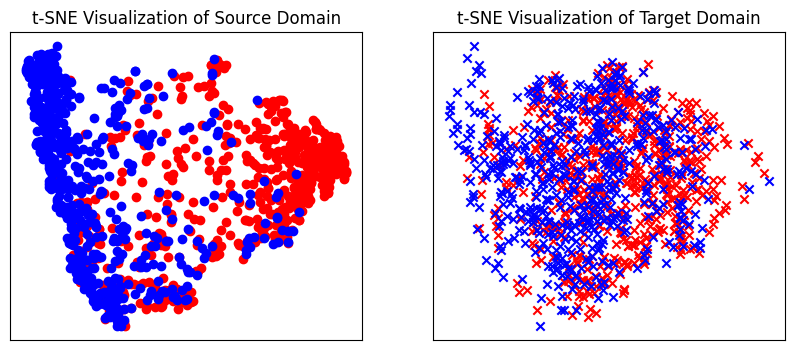

100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


the best accuracy is:  0.6046296296296296
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


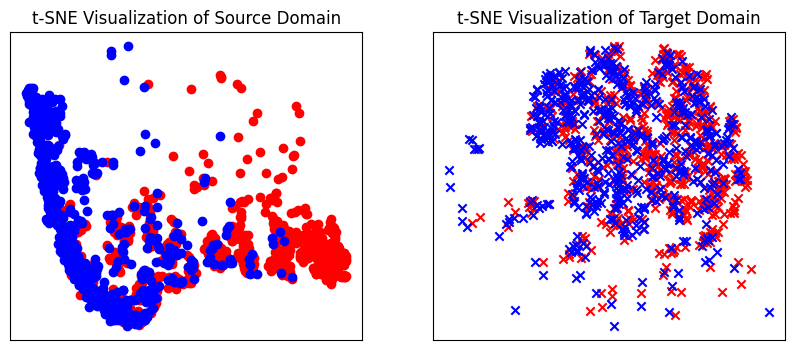

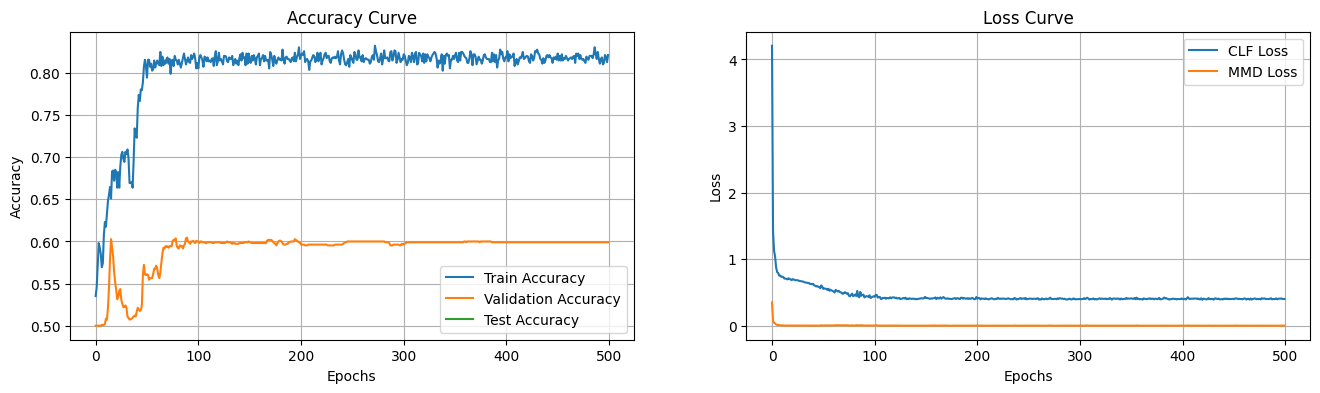

In [ ]:
model = EEGNet_DDC(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=10, batch_size=1080, epochs=500, lr=1e-2, path='DDC.jpg')

## with DA (DAN)

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 1/200 [00:00<01:00,  3.29it/s]

Model saved at epoch 1 with validation accuracy: 0.5111
LR:  0.001 0.001
classification loss: 0.6930528283119202, discrepency: 21.33917236328125


  1%|          | 2/200 [00:00<00:53,  3.70it/s]

Model saved at epoch 2 with validation accuracy: 0.5389
LR:  0.001 0.001
classification loss: 0.6927136182785034, discrepency: 16.975387573242188


  2%|▏         | 3/200 [00:00<00:48,  4.04it/s]

Model saved at epoch 3 with validation accuracy: 0.5407
LR:  0.001 0.001
classification loss: 0.6816425323486328, discrepency: 15.136690139770508


  2%|▏         | 4/200 [00:00<00:45,  4.27it/s]

classification loss: 0.6636962890625, discrepency: 12.186849594116211


  2%|▎         | 5/200 [00:01<00:44,  4.35it/s]

classification loss: 0.6388891339302063, discrepency: 7.935610771179199


  3%|▎         | 6/200 [00:01<00:43,  4.51it/s]

classification loss: 0.626142680644989, discrepency: 4.883746147155762


  4%|▎         | 7/200 [00:01<00:41,  4.61it/s]

classification loss: 0.6092166900634766, discrepency: 3.101188898086548


  4%|▍         | 8/200 [00:01<00:41,  4.68it/s]

classification loss: 0.6030217409133911, discrepency: 2.0838043689727783


  4%|▍         | 9/200 [00:02<00:40,  4.71it/s]

classification loss: 0.6326225399971008, discrepency: 1.514462947845459


  5%|▌         | 10/200 [00:02<00:39,  4.76it/s]

classification loss: 0.6307501792907715, discrepency: 1.2037259340286255


  6%|▌         | 11/200 [00:02<00:39,  4.76it/s]

classification loss: 0.5526562333106995, discrepency: 1.0168105363845825


  6%|▌         | 12/200 [00:02<00:39,  4.78it/s]

classification loss: 0.5654978156089783, discrepency: 0.8632369637489319


  6%|▋         | 13/200 [00:02<00:39,  4.76it/s]

classification loss: 0.5259100198745728, discrepency: 0.7593655586242676


  7%|▋         | 14/200 [00:03<00:39,  4.76it/s]

classification loss: 0.5235242247581482, discrepency: 0.6636650562286377


  8%|▊         | 15/200 [00:03<00:38,  4.79it/s]

classification loss: 0.5134777426719666, discrepency: 0.5912311673164368


  8%|▊         | 16/200 [00:03<00:38,  4.80it/s]

classification loss: 0.48778507113456726, discrepency: 0.5283778309822083


  8%|▊         | 17/200 [00:03<00:38,  4.79it/s]

classification loss: 0.5050563216209412, discrepency: 0.4882275462150574


  9%|▉         | 18/200 [00:03<00:37,  4.81it/s]

classification loss: 0.46697133779525757, discrepency: 0.4509413540363312


 10%|▉         | 19/200 [00:04<00:37,  4.80it/s]

classification loss: 0.4837273359298706, discrepency: 0.4237160086631775


 10%|█         | 20/200 [00:04<00:37,  4.82it/s]

classification loss: 0.46331527829170227, discrepency: 0.3969726860523224


 10%|█         | 21/200 [00:04<00:37,  4.82it/s]

classification loss: 0.4516799747943878, discrepency: 0.3797486126422882


 11%|█         | 22/200 [00:04<00:36,  4.82it/s]

classification loss: 0.430995911359787, discrepency: 0.3674801290035248


 12%|█▏        | 23/200 [00:04<00:36,  4.83it/s]

classification loss: 0.4235192835330963, discrepency: 0.3543950915336609


 12%|█▏        | 24/200 [00:05<00:36,  4.80it/s]

classification loss: 0.43479928374290466, discrepency: 0.35324761271476746


 12%|█▎        | 25/200 [00:05<00:36,  4.82it/s]

classification loss: 0.41387277841567993, discrepency: 0.34415093064308167


 13%|█▎        | 26/200 [00:05<00:36,  4.82it/s]

classification loss: 0.4052117168903351, discrepency: 0.33783769607543945


 14%|█▎        | 27/200 [00:05<00:35,  4.85it/s]

classification loss: 0.3964383006095886, discrepency: 0.33114609122276306


 14%|█▍        | 28/200 [00:05<00:35,  4.78it/s]

Model saved at epoch 28 with validation accuracy: 0.5546
LR:  0.001 0.001
classification loss: 0.3981756567955017, discrepency: 0.3295040726661682


 14%|█▍        | 29/200 [00:06<00:36,  4.72it/s]

Model saved at epoch 29 with validation accuracy: 0.5611
LR:  0.001 0.001
classification loss: 0.389757364988327, discrepency: 0.3228808641433716


 15%|█▌        | 30/200 [00:06<00:35,  4.75it/s]

classification loss: 0.385806679725647, discrepency: 0.32340526580810547


 16%|█▌        | 31/200 [00:06<00:35,  4.71it/s]

Model saved at epoch 31 with validation accuracy: 0.5704
LR:  0.001 0.001
classification loss: 0.3949891924858093, discrepency: 0.3182726800441742


 16%|█▌        | 32/200 [00:06<00:35,  4.70it/s]

Model saved at epoch 32 with validation accuracy: 0.5759
LR:  0.001 0.001
classification loss: 0.3781590461730957, discrepency: 0.3068990409374237


 16%|█▋        | 33/200 [00:07<00:35,  4.76it/s]

classification loss: 0.3717501759529114, discrepency: 0.3059352934360504


 17%|█▋        | 34/200 [00:07<00:34,  4.75it/s]

classification loss: 0.36500084400177, discrepency: 0.2948387563228607


 18%|█▊        | 35/200 [00:07<00:34,  4.76it/s]

classification loss: 0.3656505048274994, discrepency: 0.2946958839893341


 18%|█▊        | 36/200 [00:07<00:34,  4.78it/s]

classification loss: 0.35542261600494385, discrepency: 0.287428081035614


 18%|█▊        | 37/200 [00:07<00:34,  4.79it/s]

classification loss: 0.3748767375946045, discrepency: 0.28031593561172485


 19%|█▉        | 38/200 [00:08<00:33,  4.79it/s]

classification loss: 0.3593367338180542, discrepency: 0.27131348848342896


 20%|█▉        | 39/200 [00:08<00:33,  4.76it/s]

classification loss: 0.35794755816459656, discrepency: 0.2646210491657257


 20%|██        | 40/200 [00:08<00:33,  4.77it/s]

classification loss: 0.3652251660823822, discrepency: 0.26170337200164795


 20%|██        | 41/200 [00:08<00:33,  4.77it/s]

classification loss: 0.3458724319934845, discrepency: 0.2607544958591461


 21%|██        | 42/200 [00:08<00:32,  4.80it/s]

classification loss: 0.34667569398880005, discrepency: 0.25269562005996704


 22%|██▏       | 43/200 [00:09<00:33,  4.74it/s]

Model saved at epoch 43 with validation accuracy: 0.5778
LR:  0.001 0.001
classification loss: 0.3329426646232605, discrepency: 0.24760767817497253


 22%|██▏       | 44/200 [00:09<00:32,  4.77it/s]

classification loss: 0.34355607628822327, discrepency: 0.24573880434036255


 22%|██▎       | 45/200 [00:09<00:32,  4.75it/s]

Model saved at epoch 45 with validation accuracy: 0.5796
LR:  0.001 0.001
classification loss: 0.34422627091407776, discrepency: 0.24146437644958496


 23%|██▎       | 46/200 [00:09<00:32,  4.76it/s]

Model saved at epoch 46 with validation accuracy: 0.5824
LR:  0.001 0.001
classification loss: 0.32620158791542053, discrepency: 0.2350728064775467


 24%|██▎       | 47/200 [00:09<00:31,  4.79it/s]

classification loss: 0.32725170254707336, discrepency: 0.23604601621627808


 24%|██▍       | 48/200 [00:10<00:31,  4.81it/s]

classification loss: 0.33664050698280334, discrepency: 0.23017314076423645


 24%|██▍       | 49/200 [00:10<00:31,  4.82it/s]

classification loss: 0.3388373553752899, discrepency: 0.226138636469841


 25%|██▌       | 50/200 [00:10<00:31,  4.83it/s]

classification loss: 0.32963353395462036, discrepency: 0.22471953928470612


 26%|██▌       | 51/200 [00:10<00:30,  4.84it/s]

classification loss: 0.32565027475357056, discrepency: 0.22517476975917816


 26%|██▌       | 52/200 [00:11<00:30,  4.83it/s]

classification loss: 0.3126566410064697, discrepency: 0.217549666762352


 26%|██▋       | 53/200 [00:11<00:30,  4.83it/s]

classification loss: 0.3168478012084961, discrepency: 0.21226103603839874


 27%|██▋       | 54/200 [00:11<00:30,  4.83it/s]

classification loss: 0.31327536702156067, discrepency: 0.20838916301727295


 28%|██▊       | 55/200 [00:11<00:30,  4.83it/s]

classification loss: 0.3275126814842224, discrepency: 0.20754893124103546


 28%|██▊       | 56/200 [00:11<00:29,  4.85it/s]

classification loss: 0.3096085786819458, discrepency: 0.20359815657138824


 28%|██▊       | 57/200 [00:12<00:29,  4.83it/s]

classification loss: 0.3076117932796478, discrepency: 0.20349563658237457


 29%|██▉       | 58/200 [00:12<00:29,  4.83it/s]

classification loss: 0.3071531653404236, discrepency: 0.20032450556755066


 30%|██▉       | 59/200 [00:12<00:29,  4.82it/s]

classification loss: 0.3048272728919983, discrepency: 0.1968843787908554


 30%|███       | 60/200 [00:12<00:28,  4.84it/s]

classification loss: 0.3050820827484131, discrepency: 0.19440896809101105


 30%|███       | 61/200 [00:12<00:28,  4.85it/s]

classification loss: 0.30234673619270325, discrepency: 0.19087903201580048


 31%|███       | 62/200 [00:13<00:28,  4.84it/s]

classification loss: 0.31878861784935, discrepency: 0.1885448545217514


 32%|███▏      | 63/200 [00:13<00:28,  4.84it/s]

classification loss: 0.3059122860431671, discrepency: 0.18538105487823486


 32%|███▏      | 64/200 [00:13<00:28,  4.83it/s]

classification loss: 0.29550549387931824, discrepency: 0.18135513365268707


 32%|███▎      | 65/200 [00:13<00:27,  4.83it/s]

classification loss: 0.2968193292617798, discrepency: 0.1830740123987198


 33%|███▎      | 66/200 [00:13<00:27,  4.83it/s]

classification loss: 0.29761913418769836, discrepency: 0.17962545156478882


 34%|███▎      | 67/200 [00:14<00:27,  4.81it/s]

classification loss: 0.29208311438560486, discrepency: 0.1810041069984436


 34%|███▍      | 68/200 [00:14<00:27,  4.81it/s]

classification loss: 0.2808569371700287, discrepency: 0.17811577022075653


 34%|███▍      | 69/200 [00:14<00:27,  4.78it/s]

Model saved at epoch 69 with validation accuracy: 0.5833
LR:  0.001 0.001
classification loss: 0.2848692536354065, discrepency: 0.17762479186058044


 35%|███▌      | 70/200 [00:14<00:27,  4.79it/s]

classification loss: 0.295571893453598, discrepency: 0.1741441786289215


 36%|███▌      | 71/200 [00:14<00:26,  4.79it/s]

classification loss: 0.28080442547798157, discrepency: 0.1754995733499527


 36%|███▌      | 72/200 [00:15<00:26,  4.80it/s]

classification loss: 0.27837657928466797, discrepency: 0.17061646282672882


 36%|███▋      | 73/200 [00:15<00:26,  4.80it/s]

classification loss: 0.27367913722991943, discrepency: 0.1689739227294922


 37%|███▋      | 74/200 [00:15<00:26,  4.77it/s]

classification loss: 0.2756200432777405, discrepency: 0.16853666305541992


 38%|███▊      | 75/200 [00:15<00:26,  4.80it/s]

classification loss: 0.27920660376548767, discrepency: 0.16494426131248474


 38%|███▊      | 76/200 [00:15<00:25,  4.80it/s]

classification loss: 0.28046461939811707, discrepency: 0.16517989337444305


 38%|███▊      | 77/200 [00:16<00:25,  4.80it/s]

classification loss: 0.26847782731056213, discrepency: 0.16270212829113007


 39%|███▉      | 78/200 [00:16<00:25,  4.81it/s]

classification loss: 0.26686567068099976, discrepency: 0.1605381965637207


 40%|███▉      | 79/200 [00:16<00:25,  4.81it/s]

classification loss: 0.267266184091568, discrepency: 0.1592540144920349


 40%|████      | 80/200 [00:16<00:24,  4.82it/s]

classification loss: 0.2671714723110199, discrepency: 0.16149865090847015


 40%|████      | 81/200 [00:17<00:24,  4.81it/s]

classification loss: 0.2956964373588562, discrepency: 0.15872730314731598


 41%|████      | 82/200 [00:17<00:24,  4.77it/s]

Model saved at epoch 82 with validation accuracy: 0.5852
LR:  0.001 0.001
classification loss: 0.30632030963897705, discrepency: 0.16020849347114563


 42%|████▏     | 83/200 [00:17<00:24,  4.79it/s]

classification loss: 0.2826685309410095, discrepency: 0.16102832555770874


 42%|████▏     | 84/200 [00:17<00:24,  4.80it/s]

classification loss: 0.25449201464653015, discrepency: 0.16223180294036865


 42%|████▎     | 85/200 [00:17<00:23,  4.81it/s]

classification loss: 0.2632904052734375, discrepency: 0.16263779997825623


 43%|████▎     | 86/200 [00:18<00:23,  4.80it/s]

classification loss: 0.27052566409111023, discrepency: 0.15918675065040588


 44%|████▎     | 87/200 [00:18<00:23,  4.79it/s]

classification loss: 0.24650050699710846, discrepency: 0.1567259132862091


 44%|████▍     | 88/200 [00:18<00:23,  4.72it/s]

Model saved at epoch 88 with validation accuracy: 0.5861
LR:  0.001 0.001
classification loss: 0.2538630962371826, discrepency: 0.15682892501354218


 44%|████▍     | 89/200 [00:18<00:23,  4.72it/s]

classification loss: 0.26394906640052795, discrepency: 0.1520603448152542


 45%|████▌     | 90/200 [00:18<00:23,  4.74it/s]

classification loss: 0.236982524394989, discrepency: 0.1514420211315155


 46%|████▌     | 91/200 [00:19<00:22,  4.75it/s]

classification loss: 0.2561686336994171, discrepency: 0.1523105949163437


 46%|████▌     | 92/200 [00:19<00:22,  4.76it/s]

classification loss: 0.2469429224729538, discrepency: 0.15058507025241852


 46%|████▋     | 93/200 [00:19<00:22,  4.76it/s]

classification loss: 0.23681363463401794, discrepency: 0.14738988876342773


 47%|████▋     | 94/200 [00:19<00:22,  4.77it/s]

classification loss: 0.2550206184387207, discrepency: 0.15021546185016632


 48%|████▊     | 95/200 [00:19<00:22,  4.77it/s]

classification loss: 0.2325236201286316, discrepency: 0.14659848809242249


 48%|████▊     | 96/200 [00:20<00:22,  4.71it/s]

classification loss: 0.2453145980834961, discrepency: 0.14619745314121246


 48%|████▊     | 97/200 [00:20<00:21,  4.75it/s]

classification loss: 0.2379365712404251, discrepency: 0.14571453630924225


 49%|████▉     | 98/200 [00:20<00:21,  4.73it/s]

classification loss: 0.2281520515680313, discrepency: 0.1430124193429947


 50%|████▉     | 99/200 [00:20<00:21,  4.67it/s]

classification loss: 0.23128734529018402, discrepency: 0.14295417070388794


 50%|█████     | 100/200 [00:21<00:21,  4.69it/s]

classification loss: 0.21597827970981598, discrepency: 0.14298215508460999


 50%|█████     | 101/200 [00:21<00:20,  4.71it/s]

classification loss: 0.21259881556034088, discrepency: 0.14302334189414978


 51%|█████     | 102/200 [00:21<00:20,  4.74it/s]

classification loss: 0.22637277841567993, discrepency: 0.142069011926651


 52%|█████▏    | 103/200 [00:21<00:20,  4.74it/s]

classification loss: 0.2277219295501709, discrepency: 0.141197070479393


 52%|█████▏    | 104/200 [00:21<00:20,  4.74it/s]

classification loss: 0.21356822550296783, discrepency: 0.14118105173110962


 52%|█████▎    | 105/200 [00:22<00:19,  4.76it/s]

classification loss: 0.21797949075698853, discrepency: 0.14151932299137115


 53%|█████▎    | 106/200 [00:22<00:19,  4.77it/s]

classification loss: 0.22434073686599731, discrepency: 0.14026927947998047


 54%|█████▎    | 107/200 [00:22<00:19,  4.80it/s]

classification loss: 0.23260292410850525, discrepency: 0.14120018482208252


 54%|█████▍    | 108/200 [00:22<00:19,  4.77it/s]

classification loss: 0.24479886889457703, discrepency: 0.14163462817668915


 55%|█████▍    | 109/200 [00:22<00:19,  4.78it/s]

classification loss: 0.2204395830631256, discrepency: 0.14033661782741547


 55%|█████▌    | 110/200 [00:23<00:18,  4.78it/s]

classification loss: 0.22257021069526672, discrepency: 0.14280231297016144


 56%|█████▌    | 111/200 [00:23<00:18,  4.77it/s]

classification loss: 0.2290811538696289, discrepency: 0.1422240138053894


 56%|█████▌    | 112/200 [00:23<00:18,  4.76it/s]

classification loss: 0.23929822444915771, discrepency: 0.14327363669872284


 56%|█████▋    | 113/200 [00:23<00:18,  4.73it/s]

classification loss: 0.21852163970470428, discrepency: 0.14018301665782928


 57%|█████▋    | 114/200 [00:23<00:18,  4.72it/s]

classification loss: 0.2145719677209854, discrepency: 0.13999930024147034


 57%|█████▊    | 115/200 [00:24<00:17,  4.72it/s]

classification loss: 0.21718540787696838, discrepency: 0.14206264913082123


 58%|█████▊    | 116/200 [00:24<00:17,  4.72it/s]

classification loss: 0.21962203085422516, discrepency: 0.1416185349225998


 58%|█████▊    | 117/200 [00:24<00:17,  4.74it/s]

classification loss: 0.22203825414180756, discrepency: 0.1412065625190735


 59%|█████▉    | 118/200 [00:24<00:17,  4.75it/s]

classification loss: 0.22165703773498535, discrepency: 0.13888220489025116


 60%|█████▉    | 119/200 [00:25<00:17,  4.75it/s]

classification loss: 0.21574577689170837, discrepency: 0.14115175604820251


 60%|██████    | 120/200 [00:25<00:16,  4.74it/s]

classification loss: 0.21756760776042938, discrepency: 0.1409861147403717


 60%|██████    | 121/200 [00:25<00:16,  4.72it/s]

classification loss: 0.22148513793945312, discrepency: 0.13944675028324127


 61%|██████    | 122/200 [00:25<00:16,  4.73it/s]

classification loss: 0.22564677894115448, discrepency: 0.13922862708568573


 62%|██████▏   | 123/200 [00:25<00:16,  4.73it/s]

classification loss: 0.20087693631649017, discrepency: 0.1418818086385727


 62%|██████▏   | 124/200 [00:26<00:16,  4.74it/s]

classification loss: 0.22482021152973175, discrepency: 0.14137890934944153


 62%|██████▎   | 125/200 [00:26<00:15,  4.74it/s]

classification loss: 0.2161925584077835, discrepency: 0.14041882753372192


 63%|██████▎   | 126/200 [00:26<00:15,  4.74it/s]

classification loss: 0.22044308483600616, discrepency: 0.14061613380908966


 64%|██████▎   | 127/200 [00:26<00:15,  4.74it/s]

classification loss: 0.22275136411190033, discrepency: 0.13902266323566437


 64%|██████▍   | 128/200 [00:26<00:15,  4.73it/s]

classification loss: 0.21172243356704712, discrepency: 0.14042413234710693


 64%|██████▍   | 129/200 [00:27<00:15,  4.73it/s]

classification loss: 0.210452601313591, discrepency: 0.1390262395143509


 65%|██████▌   | 130/200 [00:27<00:14,  4.75it/s]

classification loss: 0.20599950850009918, discrepency: 0.1394520103931427


 66%|██████▌   | 131/200 [00:27<00:14,  4.76it/s]

classification loss: 0.22151359915733337, discrepency: 0.1376669853925705


 66%|██████▌   | 132/200 [00:27<00:14,  4.76it/s]

classification loss: 0.21490760147571564, discrepency: 0.1403568685054779


 66%|██████▋   | 133/200 [00:27<00:14,  4.75it/s]

classification loss: 0.21459054946899414, discrepency: 0.14243191480636597


 67%|██████▋   | 134/200 [00:28<00:13,  4.76it/s]

classification loss: 0.23321343958377838, discrepency: 0.1420697718858719


 68%|██████▊   | 135/200 [00:28<00:13,  4.77it/s]

classification loss: 0.21754670143127441, discrepency: 0.13761714100837708


 68%|██████▊   | 136/200 [00:28<00:13,  4.79it/s]

classification loss: 0.21366538107395172, discrepency: 0.13993075489997864


 68%|██████▊   | 137/200 [00:28<00:13,  4.80it/s]

classification loss: 0.21031278371810913, discrepency: 0.140310600399971


 69%|██████▉   | 138/200 [00:29<00:12,  4.80it/s]

classification loss: 0.2202170044183731, discrepency: 0.13945870101451874


 70%|██████▉   | 139/200 [00:29<00:12,  4.78it/s]

classification loss: 0.20995557308197021, discrepency: 0.1390019655227661


 70%|███████   | 140/200 [00:29<00:12,  4.79it/s]

classification loss: 0.21528580784797668, discrepency: 0.14178453385829926


 70%|███████   | 141/200 [00:29<00:12,  4.78it/s]

classification loss: 0.22047795355319977, discrepency: 0.1392248123884201


 71%|███████   | 142/200 [00:29<00:12,  4.77it/s]

classification loss: 0.22230258584022522, discrepency: 0.13858744502067566


 72%|███████▏  | 143/200 [00:30<00:11,  4.79it/s]

classification loss: 0.20982670783996582, discrepency: 0.13998764753341675


 72%|███████▏  | 144/200 [00:30<00:11,  4.79it/s]

classification loss: 0.20939406752586365, discrepency: 0.13859853148460388


 72%|███████▎  | 145/200 [00:30<00:11,  4.80it/s]

classification loss: 0.1948385387659073, discrepency: 0.13886311650276184


 73%|███████▎  | 146/200 [00:30<00:11,  4.80it/s]

classification loss: 0.20757117867469788, discrepency: 0.13942526280879974


 74%|███████▎  | 147/200 [00:30<00:11,  4.80it/s]

classification loss: 0.21197877824306488, discrepency: 0.14053910970687866


 74%|███████▍  | 148/200 [00:31<00:10,  4.81it/s]

classification loss: 0.21657928824424744, discrepency: 0.13997365534305573


 74%|███████▍  | 149/200 [00:31<00:10,  4.81it/s]

classification loss: 0.20162415504455566, discrepency: 0.13748885691165924


 75%|███████▌  | 150/200 [00:31<00:10,  4.80it/s]

classification loss: 0.21346411108970642, discrepency: 0.13927341997623444


 76%|███████▌  | 151/200 [00:31<00:10,  4.78it/s]

classification loss: 0.22354544699192047, discrepency: 0.13798093795776367


 76%|███████▌  | 152/200 [00:31<00:10,  4.79it/s]

classification loss: 0.20532888174057007, discrepency: 0.13912580907344818


 76%|███████▋  | 153/200 [00:32<00:09,  4.78it/s]

classification loss: 0.20593880116939545, discrepency: 0.1368892639875412


 77%|███████▋  | 154/200 [00:32<00:09,  4.79it/s]

classification loss: 0.2037668079137802, discrepency: 0.1373952329158783


 78%|███████▊  | 155/200 [00:32<00:09,  4.79it/s]

classification loss: 0.20139867067337036, discrepency: 0.1376284807920456


 78%|███████▊  | 156/200 [00:32<00:09,  4.79it/s]

classification loss: 0.2038421481847763, discrepency: 0.137694850564003


 78%|███████▊  | 157/200 [00:32<00:08,  4.79it/s]

classification loss: 0.20305976271629333, discrepency: 0.1378117799758911


 79%|███████▉  | 158/200 [00:33<00:08,  4.80it/s]

classification loss: 0.20617251098155975, discrepency: 0.1378282755613327


 80%|███████▉  | 159/200 [00:33<00:08,  4.79it/s]

classification loss: 0.220787912607193, discrepency: 0.1361282616853714


 80%|████████  | 160/200 [00:33<00:08,  4.79it/s]

classification loss: 0.20508751273155212, discrepency: 0.13310173153877258


 80%|████████  | 161/200 [00:33<00:08,  4.77it/s]

classification loss: 0.19711507856845856, discrepency: 0.13782423734664917


 81%|████████  | 162/200 [00:34<00:07,  4.79it/s]

classification loss: 0.2021038979291916, discrepency: 0.13405457139015198


 82%|████████▏ | 163/200 [00:34<00:07,  4.79it/s]

classification loss: 0.2114388346672058, discrepency: 0.13578353822231293


 82%|████████▏ | 164/200 [00:34<00:07,  4.78it/s]

classification loss: 0.2045561969280243, discrepency: 0.1353520154953003


 82%|████████▎ | 165/200 [00:34<00:07,  4.79it/s]

classification loss: 0.2145427018404007, discrepency: 0.13730274140834808


 83%|████████▎ | 166/200 [00:34<00:07,  4.78it/s]

classification loss: 0.2023797333240509, discrepency: 0.1349017322063446


 84%|████████▎ | 167/200 [00:35<00:06,  4.78it/s]

classification loss: 0.19866181910037994, discrepency: 0.13446804881095886


 84%|████████▍ | 168/200 [00:35<00:06,  4.77it/s]

classification loss: 0.20091672241687775, discrepency: 0.13543084263801575


 84%|████████▍ | 169/200 [00:35<00:06,  4.78it/s]

classification loss: 0.2075912207365036, discrepency: 0.13571466505527496


 85%|████████▌ | 170/200 [00:35<00:06,  4.79it/s]

classification loss: 0.20122525095939636, discrepency: 0.13571415841579437


 86%|████████▌ | 171/200 [00:35<00:06,  4.78it/s]

classification loss: 0.2131948620080948, discrepency: 0.13215501606464386


 86%|████████▌ | 172/200 [00:36<00:05,  4.77it/s]

classification loss: 0.20306730270385742, discrepency: 0.1346500962972641


 86%|████████▋ | 173/200 [00:36<00:05,  4.77it/s]

classification loss: 0.1999429315328598, discrepency: 0.13706350326538086


 87%|████████▋ | 174/200 [00:36<00:05,  4.76it/s]

classification loss: 0.21182705461978912, discrepency: 0.13723747432231903


 88%|████████▊ | 175/200 [00:36<00:05,  4.77it/s]

classification loss: 0.190827876329422, discrepency: 0.1359093189239502


 88%|████████▊ | 176/200 [00:36<00:05,  4.78it/s]

classification loss: 0.1998576819896698, discrepency: 0.13320250809192657


 88%|████████▊ | 177/200 [00:37<00:04,  4.77it/s]

classification loss: 0.1949521005153656, discrepency: 0.1353405863046646


 89%|████████▉ | 178/200 [00:37<00:04,  4.79it/s]

classification loss: 0.19783158600330353, discrepency: 0.13423022627830505


 90%|████████▉ | 179/200 [00:37<00:04,  4.78it/s]

classification loss: 0.1934470385313034, discrepency: 0.1350877285003662


 90%|█████████ | 180/200 [00:37<00:04,  4.77it/s]

classification loss: 0.19342491030693054, discrepency: 0.13589024543762207


 90%|█████████ | 181/200 [00:38<00:03,  4.78it/s]

classification loss: 0.20212988555431366, discrepency: 0.13583722710609436


 91%|█████████ | 182/200 [00:38<00:03,  4.77it/s]

classification loss: 0.21318569779396057, discrepency: 0.13361963629722595


 92%|█████████▏| 183/200 [00:38<00:03,  4.73it/s]

classification loss: 0.20362000167369843, discrepency: 0.13430239260196686


 92%|█████████▏| 184/200 [00:38<00:03,  4.74it/s]

classification loss: 0.1919158697128296, discrepency: 0.1315336525440216


 92%|█████████▎| 185/200 [00:38<00:03,  4.74it/s]

classification loss: 0.195057675242424, discrepency: 0.13379807770252228


 93%|█████████▎| 186/200 [00:39<00:02,  4.71it/s]

classification loss: 0.20404265820980072, discrepency: 0.13475565612316132


 94%|█████████▎| 187/200 [00:39<00:02,  4.71it/s]

classification loss: 0.19580064713954926, discrepency: 0.13217110931873322


 94%|█████████▍| 188/200 [00:39<00:02,  4.69it/s]

classification loss: 0.1948619931936264, discrepency: 0.1321057677268982


 94%|█████████▍| 189/200 [00:39<00:02,  4.70it/s]

classification loss: 0.208553746342659, discrepency: 0.13347743451595306


 95%|█████████▌| 190/200 [00:39<00:02,  4.73it/s]

classification loss: 0.19073687493801117, discrepency: 0.13276660442352295


 96%|█████████▌| 191/200 [00:40<00:01,  4.72it/s]

classification loss: 0.2006482630968094, discrepency: 0.13234536349773407


 96%|█████████▌| 192/200 [00:40<00:01,  4.72it/s]

classification loss: 0.21004030108451843, discrepency: 0.13179165124893188


 96%|█████████▋| 193/200 [00:40<00:01,  4.72it/s]

classification loss: 0.1919785588979721, discrepency: 0.13255490362644196


 97%|█████████▋| 194/200 [00:40<00:01,  4.71it/s]

classification loss: 0.19602680206298828, discrepency: 0.1334235966205597


 98%|█████████▊| 195/200 [00:40<00:01,  4.72it/s]

classification loss: 0.20448651909828186, discrepency: 0.12942346930503845


 98%|█████████▊| 196/200 [00:41<00:00,  4.74it/s]

classification loss: 0.19385865330696106, discrepency: 0.13398300111293793


 98%|█████████▊| 197/200 [00:41<00:00,  4.74it/s]

classification loss: 0.19794043898582458, discrepency: 0.13393160700798035


 99%|█████████▉| 198/200 [00:41<00:00,  4.74it/s]

classification loss: 0.1972029060125351, discrepency: 0.13416263461112976


100%|█████████▉| 199/200 [00:41<00:00,  4.75it/s]

classification loss: 0.1862252950668335, discrepency: 0.13367295265197754
classification loss: 0.19130393862724304, discrepency: 0.13169483840465546
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


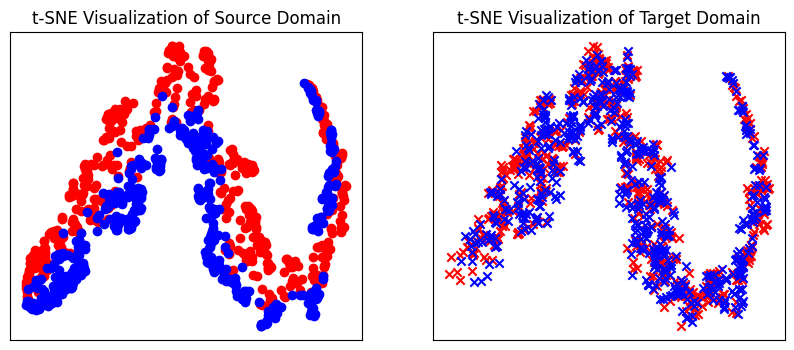

100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


the best accuracy is:  0.5861111111111111
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


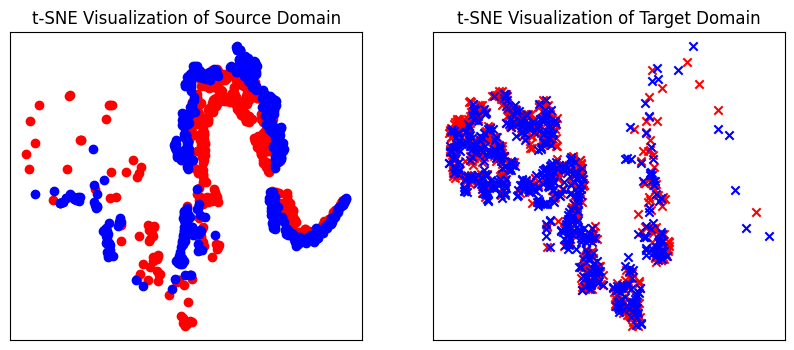

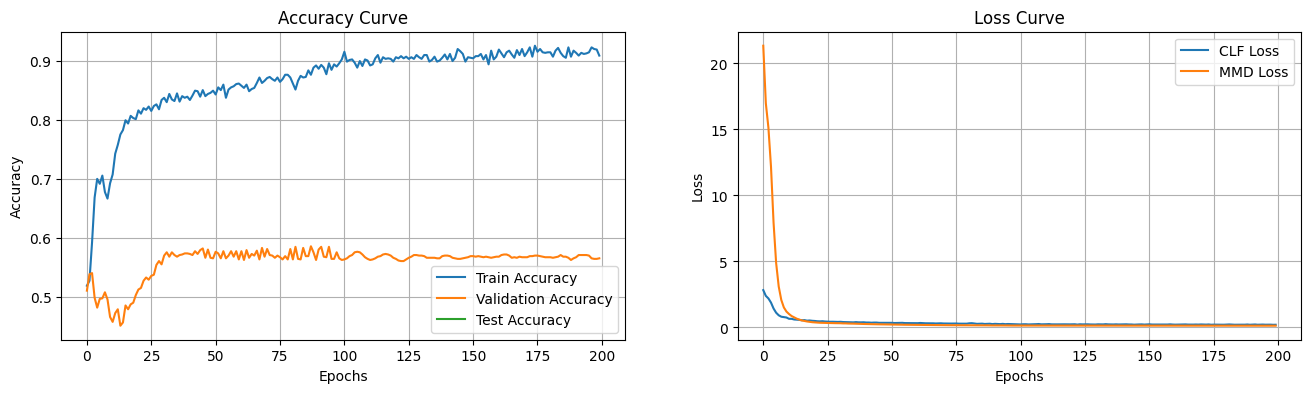

In [ ]:
model = EEGNet_DAN(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.1, batch_size=1080, epochs=200, lr=1e-2, path='DAN.jpg')
# 发现：加入MK-MMD(gaussian kernels)收敛会变困难?

### JAN

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 1/200 [00:00<01:13,  2.71it/s]

Model saved at epoch 1 with validation accuracy: 0.5009
LR:  0.001 0.001
classification loss: 0.69289630651474, discrepency: 1.0054489374160767


  1%|          | 2/200 [00:00<00:55,  3.54it/s]

classification loss: 0.6926552653312683, discrepency: 0.42264726758003235


  2%|▏         | 4/200 [00:01<00:45,  4.35it/s]

classification loss: 0.6921802759170532, discrepency: 0.19526860117912292
classification loss: 0.6912785172462463, discrepency: 0.22400450706481934


  2%|▎         | 5/200 [00:01<00:42,  4.58it/s]

classification loss: 0.6916447877883911, discrepency: 0.13319164514541626


  3%|▎         | 6/200 [00:01<00:43,  4.47it/s]

Model saved at epoch 6 with validation accuracy: 0.5083
LR:  0.001 0.001
classification loss: 0.6911892294883728, discrepency: 0.17455369234085083


  4%|▎         | 7/200 [00:01<00:42,  4.53it/s]

classification loss: 0.690529465675354, discrepency: 0.05477822944521904


  4%|▍         | 8/200 [00:01<00:41,  4.61it/s]

classification loss: 0.68979412317276, discrepency: 0.013709265738725662


  5%|▌         | 10/200 [00:02<00:40,  4.71it/s]

classification loss: 0.689924418926239, discrepency: 0.03158905729651451
classification loss: 0.6889299750328064, discrepency: 0.010286469012498856


  6%|▌         | 11/200 [00:02<00:41,  4.54it/s]

Model saved at epoch 11 with validation accuracy: 0.5148
LR:  0.001 0.001
classification loss: 0.6891689300537109, discrepency: 0.049836188554763794


  6%|▌         | 12/200 [00:02<00:41,  4.53it/s]

Model saved at epoch 12 with validation accuracy: 0.5176
LR:  0.001 0.001
classification loss: 0.687926709651947, discrepency: 0.035278093069791794


  6%|▋         | 13/200 [00:02<00:41,  4.49it/s]

Model saved at epoch 13 with validation accuracy: 0.5185
LR:  0.001 0.001
classification loss: 0.6873912811279297, discrepency: 0.10903142392635345


  7%|▋         | 14/200 [00:03<00:40,  4.63it/s]

classification loss: 0.6861239671707153, discrepency: 0.012349455617368221


  8%|▊         | 15/200 [00:03<00:39,  4.66it/s]

Model saved at epoch 15 with validation accuracy: 0.5222
LR:  0.001 0.001
classification loss: 0.6860569715499878, discrepency: 0.09713898599147797


  8%|▊         | 16/200 [00:03<00:45,  4.05it/s]

Model saved at epoch 16 with validation accuracy: 0.5241
LR:  0.001 0.001
classification loss: 0.6858805418014526, discrepency: 0.06954150646924973


  8%|▊         | 17/200 [00:03<00:44,  4.10it/s]

Model saved at epoch 17 with validation accuracy: 0.5259
LR:  0.001 0.001
classification loss: 0.6851317882537842, discrepency: 0.0714835673570633


  9%|▉         | 18/200 [00:04<00:43,  4.23it/s]

classification loss: 0.6850617527961731, discrepency: 0.07044921070337296


 10%|▉         | 19/200 [00:04<00:42,  4.30it/s]

classification loss: 0.6824880242347717, discrepency: 0.004536194261163473


 10%|█         | 20/200 [00:04<00:43,  4.11it/s]

Model saved at epoch 20 with validation accuracy: 0.5333
LR:  0.001 0.001
classification loss: 0.6824195384979248, discrepency: 0.06696455180644989


 10%|█         | 21/200 [00:04<00:42,  4.23it/s]

Model saved at epoch 21 with validation accuracy: 0.5380
LR:  0.001 0.001
classification loss: 0.6817358732223511, discrepency: 0.14835967123508453


 12%|█▏        | 24/200 [00:05<00:37,  4.73it/s]

Model saved at epoch 22 with validation accuracy: 0.5389
LR:  0.001 0.001
classification loss: 0.6800013184547424, discrepency: 0.02003675326704979
classification loss: 0.6802723407745361, discrepency: 0.15600945055484772
classification loss: 0.6790803670883179, discrepency: 0.09126108884811401


 12%|█▎        | 25/200 [00:05<00:36,  4.77it/s]

Model saved at epoch 25 with validation accuracy: 0.5407
LR:  0.001 0.001
classification loss: 0.6777046322822571, discrepency: 0.01887340098619461


 14%|█▎        | 27/200 [00:06<00:35,  4.88it/s]

Model saved at epoch 26 with validation accuracy: 0.5509
LR:  0.001 0.001
classification loss: 0.6762183904647827, discrepency: 0.036343056708574295
classification loss: 0.6752062439918518, discrepency: 0.1732720583677292


 14%|█▍        | 29/200 [00:06<00:34,  4.97it/s]

classification loss: 0.6723169684410095, discrepency: 0.08978717029094696
classification loss: 0.670748233795166, discrepency: 0.05345097929239273


 16%|█▌        | 31/200 [00:06<00:33,  5.03it/s]

classification loss: 0.6683078408241272, discrepency: 0.03703852742910385
classification loss: 0.6678407788276672, discrepency: 0.008053913712501526


 16%|█▋        | 33/200 [00:07<00:33,  5.05it/s]

classification loss: 0.6629915237426758, discrepency: 0.16584834456443787
classification loss: 0.6612628102302551, discrepency: 0.054940398782491684


 18%|█▊        | 35/200 [00:07<00:32,  5.06it/s]

classification loss: 0.6562464833259583, discrepency: 0.005739217158406973
classification loss: 0.6516677737236023, discrepency: 0.04528395086526871


 18%|█▊        | 37/200 [00:08<00:32,  5.03it/s]

Model saved at epoch 36 with validation accuracy: 0.5537
LR:  0.001 0.001
classification loss: 0.6483818888664246, discrepency: 0.07306162267923355
classification loss: 0.6458057761192322, discrepency: 0.1671515256166458


 20%|█▉        | 39/200 [00:08<00:31,  5.05it/s]

classification loss: 0.6420847773551941, discrepency: 0.04495948180556297
classification loss: 0.6371704339981079, discrepency: 0.05886192247271538


 20%|██        | 41/200 [00:08<00:31,  5.07it/s]

classification loss: 0.6325995326042175, discrepency: 0.14027468860149384
classification loss: 0.627914547920227, discrepency: 0.15854106843471527


 22%|██▏       | 43/200 [00:09<00:30,  5.07it/s]

classification loss: 0.6284324526786804, discrepency: 0.09552482515573502
classification loss: 0.62960284948349, discrepency: 0.010067829862236977


 22%|██▎       | 45/200 [00:09<00:30,  5.06it/s]

classification loss: 0.6341602802276611, discrepency: 0.06623461097478867
classification loss: 0.6345908045768738, discrepency: 0.12375261634588242


 23%|██▎       | 46/200 [00:09<00:30,  5.05it/s]

classification loss: 0.6378942131996155, discrepency: 0.12357544898986816


 24%|██▍       | 48/200 [00:10<00:30,  5.00it/s]

classification loss: 0.6407620906829834, discrepency: 0.09051072597503662
classification loss: 0.6397345662117004, discrepency: 0.20892249047756195


 24%|██▍       | 49/200 [00:10<00:30,  4.99it/s]

classification loss: 0.6421771049499512, discrepency: 0.3841986060142517


 25%|██▌       | 50/200 [00:10<00:30,  4.94it/s]

classification loss: 0.6394413709640503, discrepency: 0.08977790921926498
classification loss: 0.6362168192863464, discrepency: 0.055593155324459076


 26%|██▋       | 53/200 [00:11<00:29,  4.98it/s]

classification loss: 0.6336456537246704, discrepency: 0.1983269453048706
classification loss: 0.629226565361023, discrepency: 0.1390380561351776


 27%|██▋       | 54/200 [00:11<00:29,  4.97it/s]

classification loss: 0.6238147020339966, discrepency: 0.0956716537475586


 28%|██▊       | 55/200 [00:11<00:29,  4.93it/s]

classification loss: 0.6196925044059753, discrepency: 0.04425155371427536
classification loss: 0.6132200956344604, discrepency: 0.16056928038597107


 28%|██▊       | 57/200 [00:12<00:29,  4.92it/s]

classification loss: 0.6132965087890625, discrepency: 0.22518067061901093


 30%|██▉       | 59/200 [00:12<00:28,  4.92it/s]

Model saved at epoch 58 with validation accuracy: 0.5574
LR:  0.001 0.001
classification loss: 0.6129958033561707, discrepency: 0.035359714180231094
classification loss: 0.6139962673187256, discrepency: 0.01784312166273594


 30%|███       | 61/200 [00:12<00:28,  4.93it/s]

Model saved at epoch 60 with validation accuracy: 0.5593
LR:  0.001 0.001
classification loss: 0.6132500767707825, discrepency: 0.08686356246471405
classification loss: 0.6129646897315979, discrepency: 0.008130138739943504


 31%|███       | 62/200 [00:13<00:28,  4.85it/s]

Model saved at epoch 62 with validation accuracy: 0.5648
LR:  0.001 0.001
classification loss: 0.605470597743988, discrepency: 0.040133871138095856


 32%|███▏      | 64/200 [00:13<00:27,  4.91it/s]

Model saved at epoch 63 with validation accuracy: 0.5676
LR:  0.001 0.001
classification loss: 0.5947415232658386, discrepency: 0.17110514640808105
classification loss: 0.5855847597122192, discrepency: 0.18224266171455383


 33%|███▎      | 66/200 [00:13<00:26,  4.99it/s]

classification loss: 0.5849887132644653, discrepency: 0.15154455602169037
classification loss: 0.5922212600708008, discrepency: 0.17756038904190063


 34%|███▍      | 68/200 [00:14<00:26,  5.00it/s]

classification loss: 0.6004003286361694, discrepency: 0.057761386036872864
classification loss: 0.6086592078208923, discrepency: 0.15796980261802673


 35%|███▌      | 70/200 [00:14<00:25,  5.04it/s]

classification loss: 0.6110588312149048, discrepency: 0.11842392385005951
classification loss: 0.618291974067688, discrepency: 0.05270588397979736


 36%|███▌      | 71/200 [00:14<00:25,  5.05it/s]

classification loss: 0.6205688118934631, discrepency: 0.18641354143619537


 36%|███▋      | 73/200 [00:15<00:25,  5.01it/s]

classification loss: 0.619835376739502, discrepency: 0.11484915763139725
classification loss: 0.6240110397338867, discrepency: 0.30147647857666016


 37%|███▋      | 74/200 [00:15<00:25,  5.00it/s]

classification loss: 0.6211209893226624, discrepency: 0.05649213492870331


 38%|███▊      | 76/200 [00:15<00:24,  5.00it/s]

classification loss: 0.6158997416496277, discrepency: 0.05225183069705963
classification loss: 0.6146988272666931, discrepency: 0.12005297094583511


 38%|███▊      | 77/200 [00:16<00:25,  4.91it/s]

Model saved at epoch 77 with validation accuracy: 0.5685
LR:  0.001 0.001
classification loss: 0.6086316108703613, discrepency: 0.14494438469409943


 40%|███▉      | 79/200 [00:16<00:24,  4.94it/s]

classification loss: 0.6073644161224365, discrepency: 0.029427364468574524
classification loss: 0.5979927182197571, discrepency: 0.25693222880363464


 40%|████      | 80/200 [00:16<00:24,  4.94it/s]

classification loss: 0.5969330668449402, discrepency: 0.02894566021859646


 40%|████      | 81/200 [00:16<00:24,  4.84it/s]

Model saved at epoch 81 with validation accuracy: 0.5694
LR:  0.001 0.001
classification loss: 0.5919778347015381, discrepency: 0.00259060668759048


 41%|████      | 82/200 [00:17<00:24,  4.78it/s]

Model saved at epoch 82 with validation accuracy: 0.5769
LR:  0.001 0.001
classification loss: 0.5901491045951843, discrepency: 0.019579270854592323


 42%|████▏     | 83/200 [00:17<00:24,  4.75it/s]

Model saved at epoch 83 with validation accuracy: 0.5843
LR:  0.001 0.001
classification loss: 0.584805965423584, discrepency: 0.12926241755485535
classification loss: 0.5817275047302246, discrepency: 0.05548436567187309


 43%|████▎     | 86/200 [00:17<00:23,  4.95it/s]

classification loss: 0.5769374966621399, discrepency: 0.053276970982551575
classification loss: 0.5818615555763245, discrepency: 0.08897215873003006


 44%|████▎     | 87/200 [00:18<00:22,  4.95it/s]

classification loss: 0.5742715001106262, discrepency: 0.05873012915253639


 44%|████▍     | 88/200 [00:18<00:22,  4.93it/s]

classification loss: 0.5645099878311157, discrepency: 0.27639177441596985


 44%|████▍     | 89/200 [00:18<00:22,  4.93it/s]

classification loss: 0.5530630350112915, discrepency: 0.13263995945453644
classification loss: 0.5579680800437927, discrepency: 0.17076978087425232

 46%|████▌     | 91/200 [00:18<00:21,  4.96it/s]


classification loss: 0.58216392993927, discrepency: 0.02517828717827797


 46%|████▌     | 92/200 [00:19<00:21,  4.95it/s]

classification loss: 0.5787476897239685, discrepency: 0.0967099741101265
classification loss: 0.5801972150802612, discrepency: 0.12176896631717682

 46%|████▋     | 93/200 [00:19<00:21,  4.94it/s]

 47%|████▋     | 94/200 [00:19<00:21,  4.91it/s]

classification loss: 0.5766786932945251, discrepency: 0.09869250655174255
classification loss: 0.57416832447052, discrepency: 0.07958567142486572


 48%|████▊     | 96/200 [00:19<00:21,  4.95it/s]

classification loss: 0.5766528248786926, discrepency: 0.04614275321364403


 49%|████▉     | 98/200 [00:20<00:20,  4.95it/s]

classification loss: 0.5788230299949646, discrepency: 0.031004570424556732
classification loss: 0.5806955695152283, discrepency: 0.07346177101135254


 50%|████▉     | 99/200 [00:20<00:20,  4.94it/s]

classification loss: 0.5919772386550903, discrepency: 0.17718414962291718
classification loss: 0.5894870162010193, discrepency: 0.37578532099723816

 50%|█████     | 100/200 [00:20<00:20,  4.94it/s]

 51%|█████     | 102/200 [00:21<00:19,  4.94it/s]

Model saved at epoch 101 with validation accuracy: 0.5880
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.58439040184021, discrepency: 0.15746179223060608
classification loss: 0.5857841968536377, discrepency: 0.2136554718017578


 52%|█████▏    | 103/200 [00:21<00:19,  4.95it/s]

classification loss: 0.5819351673126221, discrepency: 0.07954796403646469


 52%|█████▏    | 104/200 [00:21<00:19,  4.95it/s]

classification loss: 0.5831912755966187, discrepency: 0.008304934948682785


 53%|█████▎    | 106/200 [00:21<00:18,  4.96it/s]

classification loss: 0.5858401656150818, discrepency: 0.072611004114151
classification loss: 0.5805636644363403, discrepency: 0.14962299168109894


 54%|█████▍    | 108/200 [00:22<00:18,  4.98it/s]

classification loss: 0.5747311115264893, discrepency: 0.0027529681101441383
classification loss: 0.5785409808158875, discrepency: 0.2963181436061859


 55%|█████▌    | 110/200 [00:22<00:17,  5.01it/s]

classification loss: 0.5760678052902222, discrepency: 0.0754159465432167
classification loss: 0.5765812993049622, discrepency: 0.13607248663902283


 56%|█████▌    | 112/200 [00:23<00:17,  5.02it/s]

classification loss: 0.5762930512428284, discrepency: 0.03141040727496147
classification loss: 0.578582227230072, discrepency: 0.01478302851319313


 57%|█████▋    | 114/200 [00:23<00:17,  5.04it/s]

classification loss: 0.5733776092529297, discrepency: 0.07093324512243271
classification loss: 0.5669658184051514, discrepency: 0.20488058030605316


 58%|█████▊    | 116/200 [00:23<00:16,  5.04it/s]

classification loss: 0.5761004686355591, discrepency: 0.13954800367355347
classification loss: 0.5751820206642151, discrepency: 0.02787662483751774


 59%|█████▉    | 118/200 [00:24<00:16,  5.03it/s]

classification loss: 0.5716462135314941, discrepency: 0.09849858283996582
classification loss: 0.5730054974555969, discrepency: 0.24412953853607178


 60%|██████    | 120/200 [00:24<00:15,  5.05it/s]

classification loss: 0.5739498138427734, discrepency: 0.05759401619434357
classification loss: 0.5661619901657104, discrepency: 0.07955937087535858


 61%|██████    | 122/200 [00:25<00:15,  5.01it/s]

classification loss: 0.5694817900657654, discrepency: 0.010386573150753975
classification loss: 0.5712708234786987, discrepency: 0.03203629329800606


 62%|██████▏   | 124/200 [00:25<00:15,  4.99it/s]

classification loss: 0.5768288373947144, discrepency: 0.13101111352443695
classification loss: 0.575011670589447, discrepency: 0.07944754511117935


 63%|██████▎   | 126/200 [00:25<00:14,  5.04it/s]

classification loss: 0.5761875510215759, discrepency: 0.11509240418672562
classification loss: 0.5685421228408813, discrepency: 0.027131401002407074


 64%|██████▍   | 128/200 [00:26<00:14,  5.02it/s]

classification loss: 0.5741990804672241, discrepency: 0.11560148000717163
classification loss: 0.5804340839385986, discrepency: 0.11667314916849136


 65%|██████▌   | 130/200 [00:26<00:13,  5.02it/s]

classification loss: 0.5744248032569885, discrepency: 0.08620619773864746
classification loss: 0.5798080563545227, discrepency: 0.15147358179092407


 66%|██████▌   | 132/200 [00:27<00:13,  5.03it/s]

classification loss: 0.5699399709701538, discrepency: 0.10700276494026184
classification loss: 0.5736327767372131, discrepency: 0.0830988958477974


 67%|██████▋   | 134/200 [00:27<00:13,  5.00it/s]

classification loss: 0.5731034874916077, discrepency: 0.23608821630477905
classification loss: 0.5746971964836121, discrepency: 0.04355546459555626


 68%|██████▊   | 135/200 [00:27<00:13,  4.98it/s]

classification loss: 0.5688183903694153, discrepency: 0.14621876180171967


 68%|██████▊   | 136/200 [00:27<00:12,  4.97it/s]

classification loss: 0.5718870759010315, discrepency: 0.10134076327085495


 68%|██████▊   | 137/200 [00:28<00:12,  4.95it/s]

classification loss: 0.568910539150238, discrepency: 0.06641428917646408
classification loss: 0.5686768889427185, discrepency: 0.00015764588897582144

 69%|██████▉   | 138/200 [00:28<00:12,  4.96it/s]

 70%|██████▉   | 139/200 [00:28<00:12,  4.94it/s]

classification loss: 0.5596449971199036, discrepency: 0.027716318145394325


 70%|███████   | 141/200 [00:28<00:11,  4.94it/s]

classification loss: 0.5605788230895996, discrepency: 0.13955499231815338
classification loss: 0.5650209784507751, discrepency: 0.09277250617742538


 71%|███████   | 142/200 [00:29<00:11,  4.95it/s]

classification loss: 0.5635629296302795, discrepency: 0.04469044506549835


 72%|███████▏  | 144/200 [00:29<00:11,  4.94it/s]

Model saved at epoch 143 with validation accuracy: 0.5898
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.5538458824157715, discrepency: 0.07822782546281815
classification loss: 0.5627630949020386, discrepency: 0.047024551779031754


 72%|███████▎  | 145/200 [00:29<00:11,  4.94it/s]

classification loss: 0.557671070098877, discrepency: 0.05275173485279083


 74%|███████▍  | 148/200 [00:30<00:10,  4.96it/s]

Model saved at epoch 146 with validation accuracy: 0.5917
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.5518569946289062, discrepency: 0.06457174569368362
classification loss: 0.5554898381233215, discrepency: 0.14646846055984497
classification loss: 0.5579265356063843, discrepency: 0.036980606615543365


 74%|███████▍  | 149/200 [00:30<00:10,  4.98it/s]

classification loss: 0.5587868690490723, discrepency: 0.07696717977523804


 76%|███████▌  | 152/200 [00:31<00:09,  5.00it/s]

Model saved at epoch 150 with validation accuracy: 0.5935
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.5569307208061218, discrepency: 0.13541100919246674
Model saved at epoch 151 with validation accuracy: 0.5944
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.5622556805610657, discrepency: 0.045157380402088165
classification loss: 0.5573374032974243, discrepency: 0.1013745665550232


 77%|███████▋  | 154/200 [00:31<00:09,  5.00it/s]

classification loss: 0.5603972673416138, discrepency: 0.0393136665225029
classification loss: 0.5517510175704956, discrepency: 0.08482280373573303


 78%|███████▊  | 155/200 [00:31<00:09,  4.98it/s]

classification loss: 0.5646278262138367, discrepency: 0.1987416297197342


 78%|███████▊  | 156/200 [00:32<00:09,  4.89it/s]

Model saved at epoch 156 with validation accuracy: 0.5954
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.5607300996780396, discrepency: 0.1110839694738388
classification loss: 0.56441730260849, discrepency: 0.0004161357937846333

 78%|███████▊  | 157/200 [00:32<00:08,  4.92it/s]


classification loss: 0.5678433775901794, discrepency: 0.00823162030428648

 79%|███████▉  | 158/200 [00:32<00:08,  4.93it/s]

 80%|███████▉  | 159/200 [00:32<00:08,  4.88it/s]

Model saved at epoch 159 with validation accuracy: 0.5972
LR:  0.00010000000000000002 0.00010000000000000002
classification loss: 0.5673274397850037, discrepency: 0.14080414175987244
classification loss: 0.5655558705329895, discrepency: 0.0715857595205307

 80%|████████  | 160/200 [00:32<00:08,  4.93it/s]


classification loss: 0.569599986076355, discrepency: 0.16312097012996674

 80%|████████  | 161/200 [00:33<00:07,  4.94it/s]

 81%|████████  | 162/200 [00:33<00:07,  4.93it/s]

classification loss: 0.5643906593322754, discrepency: 0.12785539031028748


 82%|████████▏ | 164/200 [00:33<00:07,  4.95it/s]

classification loss: 0.5612912774085999, discrepency: 0.026215599849820137
classification loss: 0.560814619064331, discrepency: 0.10662928223609924


 83%|████████▎ | 166/200 [00:34<00:06,  4.95it/s]

classification loss: 0.5709130764007568, discrepency: 0.14251789450645447
classification loss: 0.5582922101020813, discrepency: 0.016820494085550308


 84%|████████▎ | 167/200 [00:34<00:06,  4.94it/s]

classification loss: 0.5583284497261047, discrepency: 0.12699896097183228


 84%|████████▍ | 168/200 [00:34<00:06,  4.93it/s]

classification loss: 0.5615874528884888, discrepency: 0.03917209059000015


 84%|████████▍ | 169/200 [00:34<00:06,  4.92it/s]

classification loss: 0.5586476922035217, discrepency: 0.03327730670571327
classification loss: 0.5528563857078552, discrepency: 0.011889686807990074

 85%|████████▌ | 170/200 [00:34<00:06,  4.92it/s]

 86%|████████▌ | 171/200 [00:35<00:05,  4.91it/s]

classification loss: 0.5567545890808105, discrepency: 0.03257809579372406


 86%|████████▌ | 172/200 [00:35<00:05,  4.91it/s]

classification loss: 0.5594232082366943, discrepency: 0.10552657395601273
classification loss: 0.5546435117721558, discrepency: 0.011558081954717636

 86%|████████▋ | 173/200 [00:35<00:05,  4.92it/s]

 87%|████████▋ | 174/200 [00:35<00:05,  4.93it/s]

classification loss: 0.5586165189743042, discrepency: 0.2446877360343933
classification loss: 0.5510420203208923, discrepency: 0.09599219262599945

 88%|████████▊ | 175/200 [00:35<00:05,  4.93it/s]

 88%|████████▊ | 176/200 [00:36<00:04,  4.94it/s]

classification loss: 0.5532627105712891, discrepency: 0.02852175012230873


 88%|████████▊ | 177/200 [00:36<00:04,  4.92it/s]

classification loss: 0.5528959631919861, discrepency: 0.03628316894173622
classification loss: 0.5519346594810486, discrepency: 0.08494883030653


 90%|████████▉ | 179/200 [00:36<00:04,  4.94it/s]

classification loss: 0.5474710464477539, discrepency: 0.2580258846282959


 90%|█████████ | 180/200 [00:36<00:04,  4.90it/s]

classification loss: 0.5502145886421204, discrepency: 0.0756513774394989


 90%|█████████ | 181/200 [00:37<00:03,  4.90it/s]

classification loss: 0.54461669921875, discrepency: 0.12814104557037354
classification loss: 0.5458080768585205, discrepency: 0.11753254383802414


 92%|█████████▏| 183/200 [00:37<00:03,  4.93it/s]

classification loss: 0.5488156080245972, discrepency: 0.07540260255336761
classification loss: 0.5480342507362366, discrepency: 0.17153725028038025

 92%|█████████▏| 184/200 [00:37<00:03,  4.91it/s]

 93%|█████████▎| 186/200 [00:38<00:02,  4.95it/s]

classification loss: 0.55405592918396, discrepency: 0.025554629042744637
classification loss: 0.5498913526535034, discrepency: 0.2089039832353592


 94%|█████████▎| 187/200 [00:38<00:02,  4.92it/s]

classification loss: 0.5504323244094849, discrepency: 0.08867593854665756


 94%|█████████▍| 189/200 [00:38<00:02,  4.96it/s]

classification loss: 0.5545837879180908, discrepency: 0.020644236356019974
classification loss: 0.5540056824684143, discrepency: 0.03539042919874191


 95%|█████████▌| 190/200 [00:38<00:02,  4.95it/s]

classification loss: 0.5506415367126465, discrepency: 0.00726108904927969
classification loss: 0.5571020245552063, discrepency: 0.1256001591682434


 96%|█████████▌| 192/200 [00:39<00:01,  4.97it/s]

classification loss: 0.5527901649475098, discrepency: 0.05705966800451279


 96%|█████████▋| 193/200 [00:39<00:01,  4.93it/s]

classification loss: 0.5560461282730103, discrepency: 0.0637965276837349


 97%|█████████▋| 194/200 [00:39<00:01,  4.93it/s]

classification loss: 0.550984799861908, discrepency: 0.037636883556842804
classification loss: 0.5428538918495178, discrepency: 0.13776226341724396

 98%|█████████▊| 195/200 [00:39<00:01,  4.94it/s]


classification loss: 0.5502312779426575, discrepency: 0.13768287003040314


 98%|█████████▊| 197/200 [00:40<00:00,  4.95it/s]

classification loss: 0.5539010167121887, discrepency: 0.0013878857716917992


 99%|█████████▉| 198/200 [00:40<00:00,  4.92it/s]

classification loss: 0.5515472888946533, discrepency: 0.10030298680067062


100%|█████████▉| 199/200 [00:40<00:00,  4.92it/s]

classification loss: 0.5483547449111938, discrepency: 0.0626554936170578
classification loss: 0.552013099193573, discrepency: 0.124810591340065
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


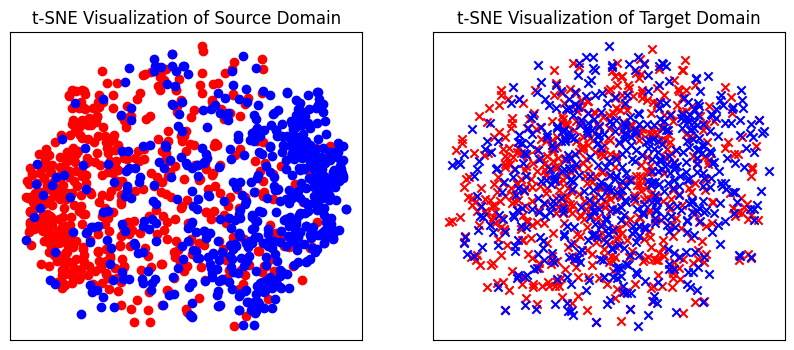

100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


the best accuracy is:  0.5972222222222222
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


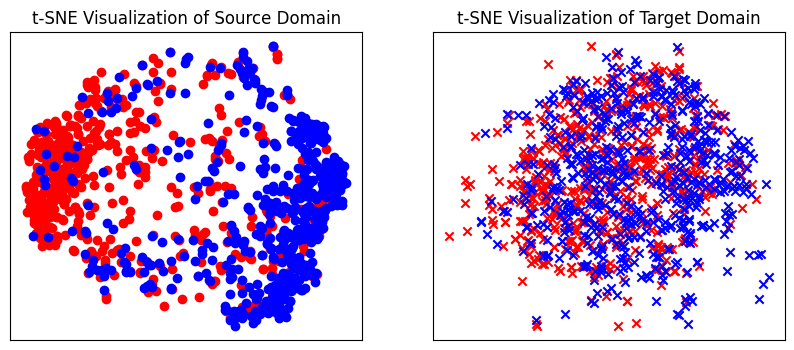

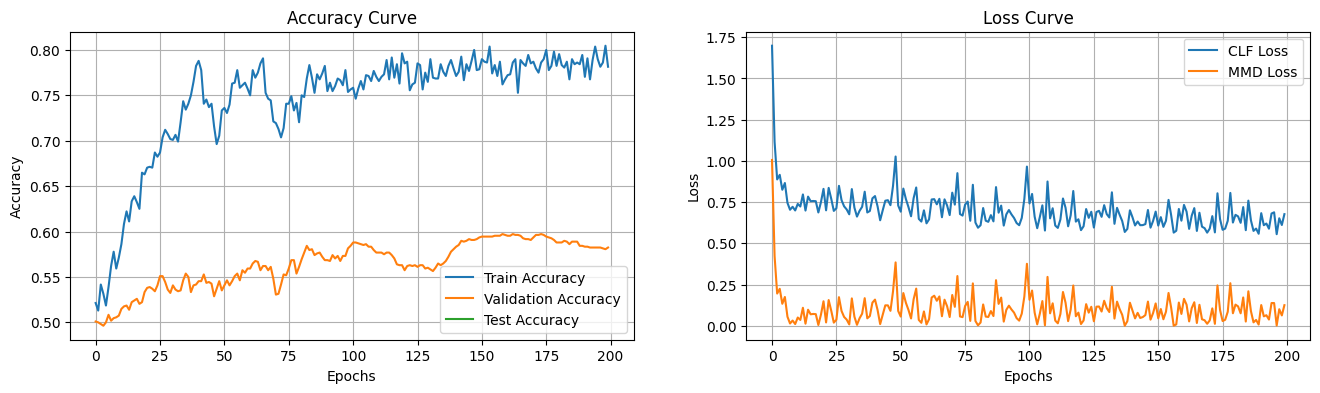

In [ ]:
model = EEGNet_JAN(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=1, batch_size=1080, epochs=200, lr=1e-2, path='JAN', format='jpg')

# DJP-MMD

In [ ]:
# MMD, JMMD, JPMMD, DJP-MMD
def mmd_loss(x_src, y_src, x_tar, y_pseudo, mmd_type):
    if mmd_type == 'mmd':
        return rbf_mmd(x_src, x_tar, SIGMA)
    elif mmd_type == 'jmmd':
        return rbf_jmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'jpmmd':
        return rbf_jpmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'djpmmd':
        return rbf_djpmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)


def test(data, label, model):
    model.eval()
    with torch.no_grad():
        data, label = data.to(DEVICE), label.to(DEVICE)
        pred, _, _ = model(data, data)

        correct_cnt = (torch.max(pred, 1)[1] == label).sum().item()
        sample_cnt = data.shape[0]
        accuracy = correct_cnt / sample_cnt

    return accuracy

def lr_lambda(epoch):
    if epoch < 100:
        return 0.1
    else:
        lr = 0.1 ** ((epoch // 100) + 1)
        return 1e-4 if lr < 1e-4 else lr


def train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, batch_size=1080, epochs=500, lr=1e-1, path='test', format='jpg'):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr = lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)
    lr_scheduler = LambdaLR(optimizer, lr_lambda)

    model.to(DEVICE)

    mmd_type = 'djpmmd'
    y_pse = torch.zeros(1080).long().cuda()

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        source_data, source_label = source_data.to(DEVICE), source_label.to(DEVICE)
        target_data = target_data.to(DEVICE)
        val_data, val_label = val_data.to(DEVICE), val_label.to(DEVICE)

        y_src, features_src, features_tar = model(source_data, val_data)
        # print("fshj", y_src.shape)
        # print(len(torch.unique(y_src)))

        # compute loss
        clf_loss = loss_fn(y_src, source_label)
        # loss_mmd = mmd_loss(features_src, source_label.long(), features_tar, y_pse, mmd_type) # use true lable in the source domain to compute loss
        loss_mmd = CS(features_src, features_tar, 1, median_sigma=0)  + CCS(features_src, features_tar, source_label.float(), y_pse.float(), 1, median_sigma=0)
        # float(): RuntimeError: "dot" not implemented for 'Long', PyTorch 的 dot 函数不支持这种数据类型。dot 函数通常用于浮点数类型的张量，如 float32 或 float64

        loss = clf_loss + lambda_factor * loss_mmd
        # loss = clf_loss / lambda_factor + loss_mmd

        model.eval()
        y_pse, _, _ = model(val_data, val_data)
        y_pse = y_pse.detach().max(1)[1]

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(loss_mmd.item())

        correct_cnt = (torch.max(y_src, 1)[1] == source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()


        val_accuracy = test(val_data, val_label, model)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'DA_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')

            print("LR: ", lr_scheduler.get_last_lr()[0], optimizer.state_dict()['param_groups'][0]['lr'])
        print(f'classification loss: {clf_loss.item()}, discrepency: {loss_mmd.item()}')

        if epoch == epochs - 1:
            tsne_visulization(features_src.cpu().detach().numpy(), features_tar.cpu().detach().numpy(), path='original.jpg')


    print("the best accuracy is: ", best_acc)
    with torch.no_grad():
        model.load_state_dict(torch.load("DA_best_model.pth"))
        _, source_features, val_features = model(source_data.to(DEVICE), val_data.to(DEVICE))
        tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    # plt.show()


    plt.subplot(1, 2, 2)
    plt.plot(clf_loss_history, label="CLF Loss")
    plt.plot(mmd_loss_history, label='MMD Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()

In [ ]:
# LEARNING RATE FROM 1e-4 to 1e-1
model = EEGNet_DA1(n_output=2)
model.apply(init_weights)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.1, batch_size=1080, epochs=200, lr=1e-2, path='DJPMMD', format='jpg')

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  1%|          | 2/200 [00:00<00:51,  3.88it/s]

Model saved at epoch 1 with validation accuracy: 0.5000
LR:  1.0000000000000002e-06 1.0000000000000002e-06
classification loss: 0.8060504198074341, discrepency: inf
classification loss: nan, discrepency: nan


  2%|▏         | 3/200 [00:00<00:46,  4.22it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


  2%|▏         | 4/200 [00:00<00:43,  4.48it/s]

classification loss: nan, discrepency: nan

  2%|▎         | 5/200 [00:01<00:42,  4.64it/s]

  3%|▎         | 6/200 [00:01<00:44,  4.37it/s]

classification loss: nan, discrepency: nan


  4%|▎         | 7/200 [00:01<00:45,  4.27it/s]

classification loss: nan, discrepency: nan


  4%|▍         | 8/200 [00:01<00:45,  4.20it/s]

classification loss: nan, discrepency: nan


  4%|▍         | 9/200 [00:02<00:45,  4.21it/s]

classification loss: nan, discrepency: nan


  5%|▌         | 10/200 [00:02<00:46,  4.11it/s]

classification loss: nan, discrepency: nan


  6%|▌         | 11/200 [00:02<00:45,  4.11it/s]

classification loss: nan, discrepency: nan


  6%|▌         | 12/200 [00:02<00:45,  4.13it/s]

classification loss: nan, discrepency: nan


  6%|▋         | 13/200 [00:03<00:44,  4.20it/s]

classification loss: nan, discrepency: nan


  7%|▋         | 14/200 [00:03<00:44,  4.20it/s]

classification loss: nan, discrepency: nan


  8%|▊         | 15/200 [00:03<00:43,  4.27it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan

  8%|▊         | 16/200 [00:03<00:41,  4.44it/s]

  8%|▊         | 17/200 [00:03<00:40,  4.54it/s]

classification loss: nan, discrepency: nan


  9%|▉         | 18/200 [00:04<00:39,  4.65it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan

 10%|█         | 20/200 [00:04<00:37,  4.84it/s]


classification loss: nan, discrepency: nan


 11%|█         | 22/200 [00:04<00:35,  4.98it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 12%|█▏        | 24/200 [00:05<00:34,  5.03it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 13%|█▎        | 26/200 [00:05<00:34,  5.04it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 14%|█▍        | 28/200 [00:06<00:32,  5.25it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 15%|█▌        | 30/200 [00:06<00:31,  5.37it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 16%|█▌        | 32/200 [00:06<00:31,  5.42it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 17%|█▋        | 34/200 [00:07<00:30,  5.45it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 18%|█▊        | 36/200 [00:07<00:29,  5.48it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 19%|█▉        | 38/200 [00:07<00:29,  5.48it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 20%|██        | 40/200 [00:08<00:29,  5.46it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 21%|██        | 42/200 [00:08<00:28,  5.46it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 22%|██▏       | 44/200 [00:09<00:28,  5.46it/s]

classification loss: nan, discrepency: nan
classification loss: nan, discrepency: nan


 22%|██▏       | 44/200 [00:09<00:32,  4.76it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.cuda.device_count()

1

## TCA

In [ ]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)

        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)

        return acc, y_pred

    # TCA code is done here. You can ignore fit_new and fit_predict_new.

    def fit_new(self, Xs, Xt, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        # Computing projection matrix A from Xs an Xt
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot(
            [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]

        # Compute kernel with Xt2 as target and X as source
        Xt2 = Xt2.T
        K = kernel(self.kernel_type, X1=Xt2, X2=X, gamma=self.gamma)

        # New target features
        Xt2_new = K @ A

        return Xt2_new

    def fit_predict_new(self, Xt, Xs, Ys, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, _ = self.fit(Xs, Xt)
        Xt2_new = self.fit_new(Xs, Xt, Xt2)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred


def train_valid(source_data, source_lable, val_data, val_label, target_data, target_label):

    source_data, val_data, target_data = source_data.reshape(source_data.shape[0], -1), val_data.reshape(val_data.shape[0], -1), target_data.reshape(target_data.shape[0], -1)

    # Create latent space and evaluate using Xs and Xt1
    tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
    acc1, ypre1 = tca.fit_predict(source_data, source_label, val_data, val_label)

    # Project and evaluate Xt2 existing projection matrix and classifier
    acc2, ypre2 = tca.fit_predict_new(val_data, source_data, source_label, target_data, target_label)

    print(f'Accuracy of mapped source and target1 data : {acc1:.3f}')  # 0.800
    print(f'Accuracy of mapped target2 data            : {acc2:.3f}')  # 0.706




In [ ]:
train_valid(source_data, source_label, val_data, val_label, target_data, target_label)

In [ ]:
tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
acc, ypred = tca.fit_predict(source_data, source_label, target_data, target_label)
print(f'Accuracy: {acc:.3f}')

## DaNN